Variables:              
- dat_tr - data per one trial (one regione of one mouse, just white noise)            
- dat_stan/aw - data per one state of the mouse (anest/awake)              
- dat_sean/aw - data per session                   
- df_corr_an/aw - dataframe of correlation (correlation matrix)
- top50_change_tr - info: num_tr, mouse, region, session, position

##### Importing required packages and libraries 

In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cmath import nan

##### Loading .mat files - respPeak = peak of ind, allROIPositions

In [3]:
mat_load = sio.loadmat('C:/Users/m.nedeljkovic/Desktop/respPeak.mat')['x']
roi_load = sio.loadmat('C:/Users/m.nedeljkovic/Desktop/allROIPositions.mat')['allROIPositions']

##### General functions

In [4]:
#Dividing data into trials, anst state and awake state

def divide_data(index, trial, mat_load):

    index[trial] = index[trial] + index[trial-1]
    dat_tr = mat_load[index[trial-1] : index[trial]+1, :, :, 0, :, :]

    #choose state
    dat_stan = dat_tr[:, 0, :, :, :]
    dat_staw = dat_tr[:, 1, :, :, :]
    return index, dat_tr, dat_stan, dat_staw

In [5]:
#make dict to convert to dataframe

def make_dict(dat_sean, dat_seaw):

    dat_dict_an = {}
    dat_dict_aw = {}

    for matrix in range(np.shape(dat_sean)[0]):
        dat_dict_an[matrix] = dat_sean[matrix].flatten()
        dat_dict_aw[matrix] = dat_seaw[matrix].flatten()

    dat_df_an = pd.DataFrame(dat_dict_an, index=None).astype(float)
    dat_df_aw = pd.DataFrame(dat_dict_aw, index=None).astype(float)
    return dat_df_an, dat_df_aw

def make_dict_one_speaker(dat_sean, dat_seaw, num):

    dat_dict_an = {}
    dat_dict_aw = {}

    for matrix in range(np.shape(dat_sean)[0]):
        dat_dict_an[matrix] = dat_sean[matrix][num]
        dat_dict_aw[matrix] = dat_seaw[matrix][num]

    dat_df_an = pd.DataFrame(dat_dict_an, index=None).astype(float)
    dat_df_aw = pd.DataFrame(dat_dict_aw, index=None).astype(float)
    return dat_df_an, dat_df_aw

In [6]:
#exclude the rows/columns which index is not in the other dataframe

def exclude_nan(dat_df_an, dat_df_aw):

    df_corr_an = dat_df_an.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
    df_corr_aw = dat_df_aw.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

    mask = df_corr_aw.index.isin(df_corr_an.index)
    df_corr_aw = df_corr_aw.loc[mask]
    mask = df_corr_an.index.isin(df_corr_aw.index)
    df_corr_an = df_corr_an.loc[mask]
    mask = []
    for x in df_corr_an.columns:
        if x not in df_corr_aw.columns:
            mask.append(x)
    df_corr_an = df_corr_an.drop(columns=mask)
    mask = []
    for x in df_corr_aw.columns:
        if x not in df_corr_an.columns:
            mask.append(x)
    df_corr_aw = df_corr_aw.drop(columns=mask)

    return df_corr_an, df_corr_aw

##### Noise correlation of the neurons (first-anes, second-awake)

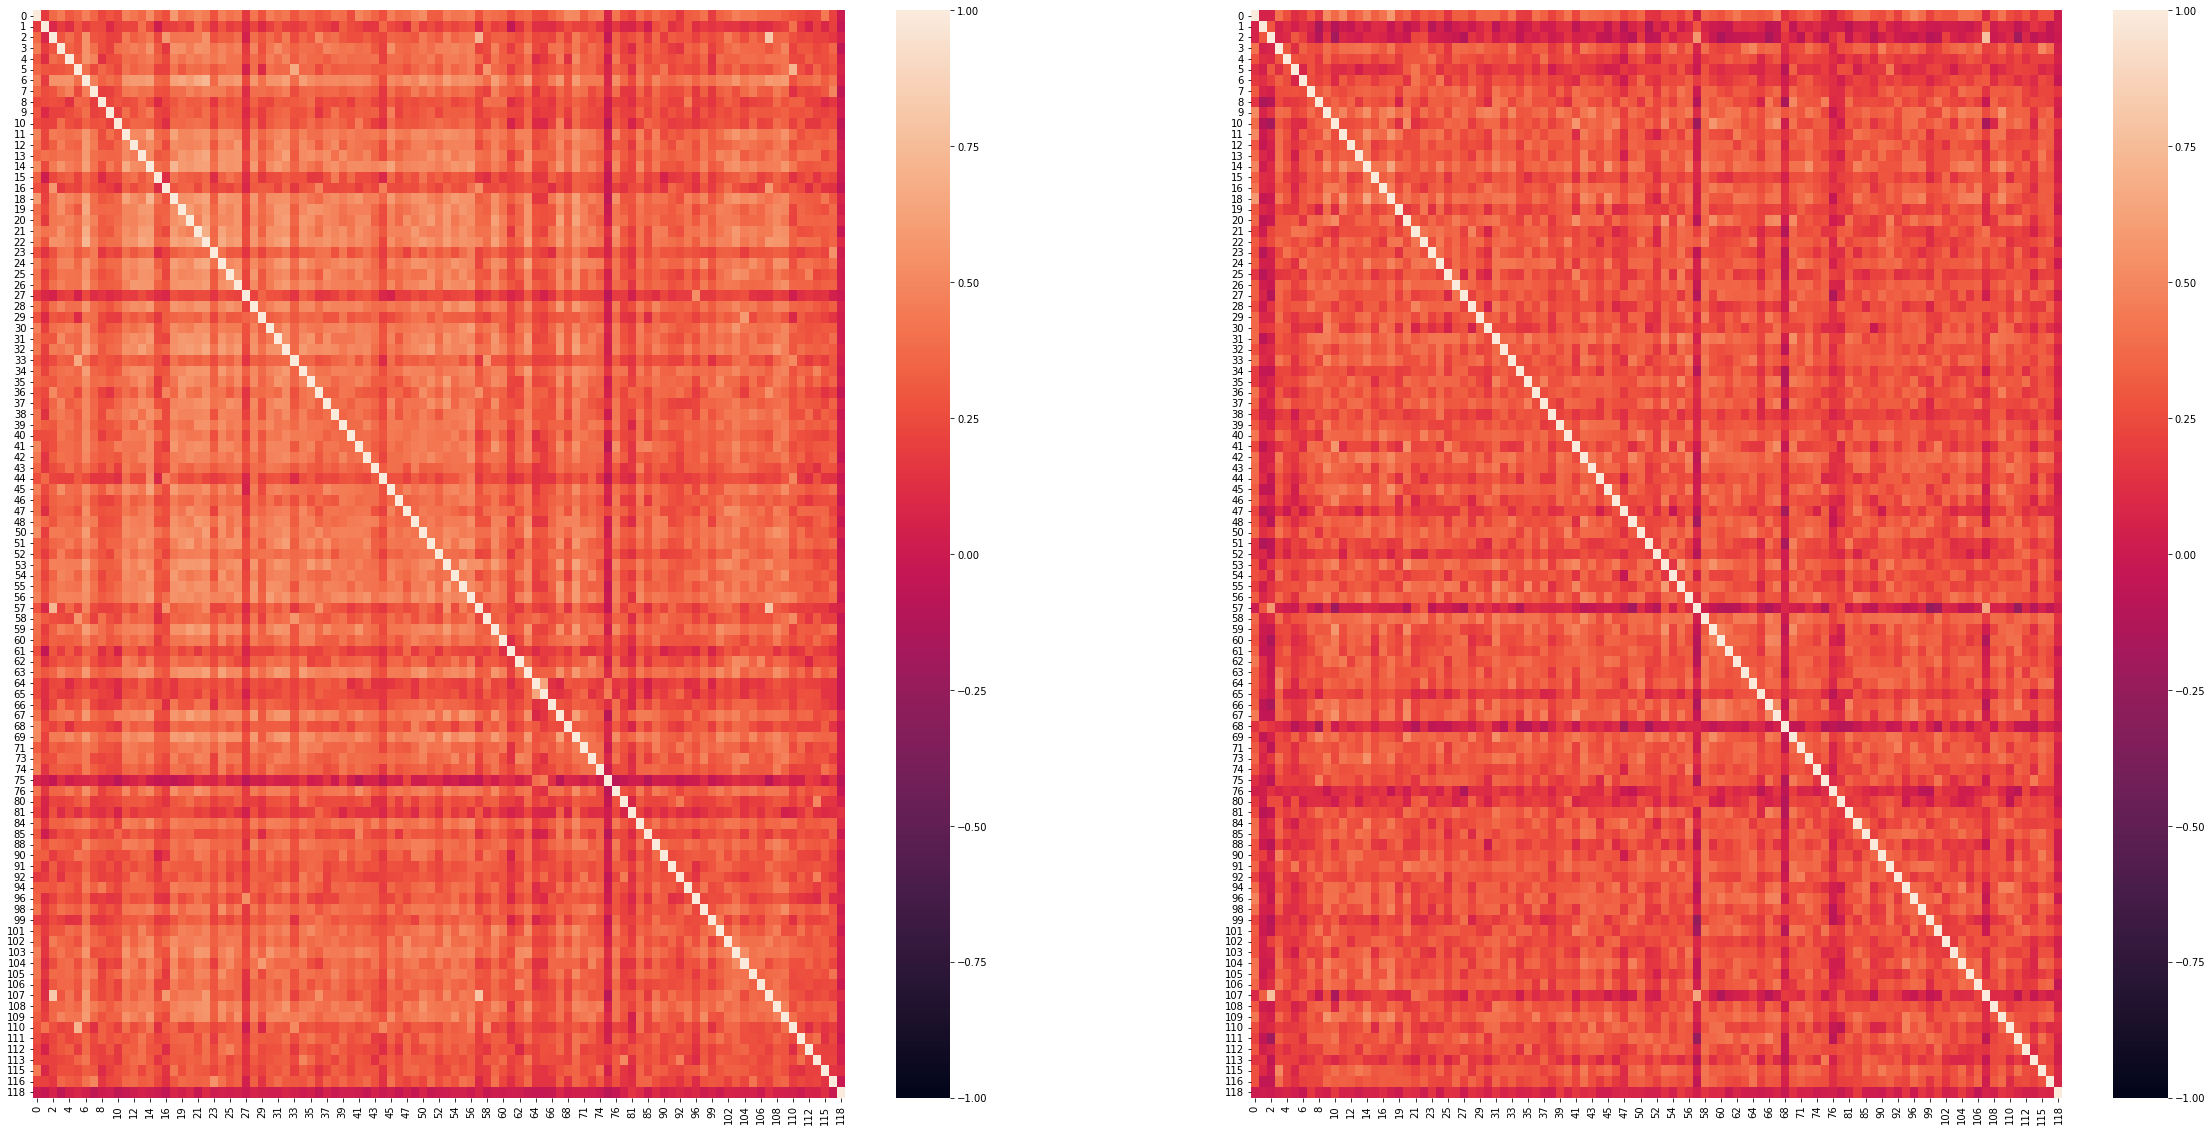

In [7]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    
    for sesion in range(4):

        f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(40, 20))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        #plot the correlation matrix
        sns.heatmap(df_corr_an, vmax=1, vmin=-1, ax=ax1)
        sns.heatmap(df_corr_aw, vmax=1, vmin=-1, ax=ax2)

        break
    break

##### Comparing correlation matrices in the anesthetized and in the awake state

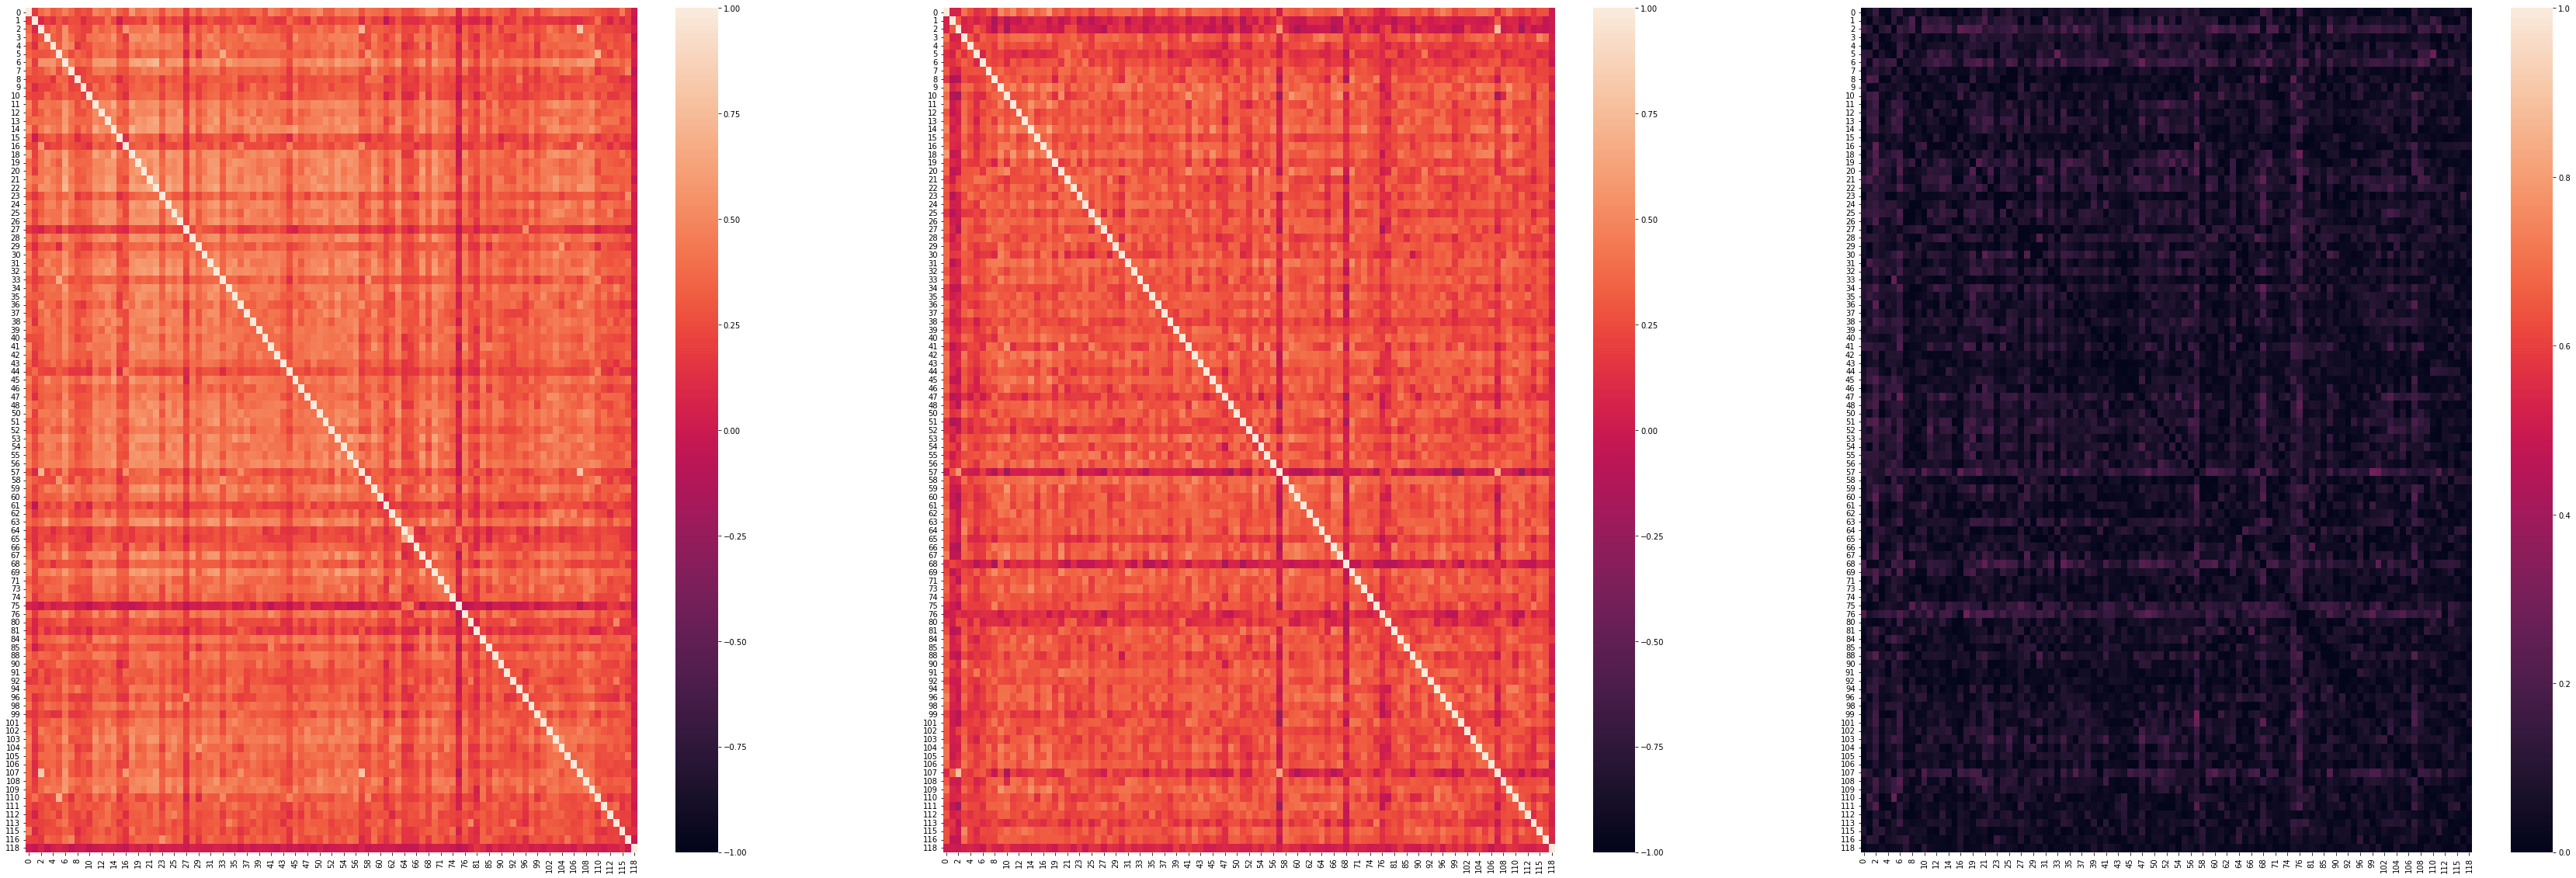

In [8]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    
    for sesion in range(4):

        f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=False,figsize=(60, 20))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        #difference between the two correlation matrices
        df_corr_diff = abs(df_corr_an - df_corr_aw)/2

        #plot the correlation matrix
        sns.heatmap(df_corr_an, vmax=1, vmin=-1, ax=ax1)
        sns.heatmap(df_corr_aw, vmax=1, vmin=-1, ax=ax2)
        sns.heatmap(df_corr_diff, vmax=1, vmin=0, ax=ax3)

        break
    break

##### Top 10 anticorrelated neurons (increase/decrease) per trial

In [9]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]
all_dict = []

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    
    for sesion in range(4):
        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        #difference between the two correlation matrices
        df_corr_diff_inc = (df_corr_aw - df_corr_an)/2
        df_corr_diff_dec = (df_corr_an - df_corr_aw)/2
        
        #finding max differences in the whole dataframe
        top_inc = df_corr_diff.stack().nlargest(20).index.tolist()
        del top_inc[1::2]
        top_dec = df_corr_diff.stack().nlargest(20).index.tolist()
        del top_dec[1::2]

        #saving the data as dictionary
        top_change_tr = {}
        top_change_tr['inc'] = top_inc
        top_change_tr['inc_val'] = df_corr_diff_inc.stack().nlargest(20).values.tolist()[1::2]
        top_change_tr['dec'] = top_dec
        top_change_tr['dec_val'] = df_corr_diff_dec.stack().nlargest(20).values.tolist()[1::2]
        top_change_tr['tr'] = trial
        top_change_tr['mouse'] = (trial + 1)//2
        top_change_tr['region'] = 1 if(trial%2 != 0) else 2
        top_change_tr['ses'] = sesion + 1

        #print(top_change_tr)
        all_dict.append(top_change_tr)

##### Top 50 anticorrelated neurons overall

In [10]:
vals = []
info = []

for i in all_dict:
    for j in range(10):
        vals.append(i['inc_val'][j])
        info.append([i['tr'], i['mouse'], i['region'], i['ses'], i['inc'][j]])
    for j in range(10):
        vals.append(i['dec_val'][j])
        info.append([i['tr'], i['mouse'], i['region'], i['ses'], i['dec'][j]])

vals_sort = [x for x, y in sorted(zip(vals, info), reverse=True)]
info_sort = [y for x, y in sorted(zip(vals, info), reverse=True)]

top50_change_tr = {}
top50_change_tr['vals'] = vals_sort[:50]
top50_change_tr['info'] = info_sort[:50]

print(top50_change_tr)

{'vals': [0.6010290604179849, 0.5230466502627443, 0.48231102968951595, 0.4763422522667041, 0.45789177818454674, 0.45268075198764196, 0.4466735265442262, 0.4389665551883061, 0.43694585623216775, 0.4351809302175767, 0.4312971707275003, 0.428548184730953, 0.42662574732964387, 0.4259166325325614, 0.4255491917494225, 0.4242248051005278, 0.4167804565217056, 0.4078438008170696, 0.40613963547598797, 0.4051805928052449, 0.40127963006052325, 0.3999795380660467, 0.397491674917706, 0.39711379862281226, 0.3962778429749968, 0.39227102339880726, 0.39109911224877253, 0.3883286115583727, 0.38675304969396995, 0.38634567747915094, 0.3862263097950711, 0.38514114913832487, 0.3845637689537513, 0.38338237284828924, 0.3811134139286722, 0.3807086289127671, 0.37887952095138167, 0.3777378404147834, 0.37756817628110445, 0.3769674690599289, 0.376955862345931, 0.37677623427713725, 0.37574033082302905, 0.37313601631013527, 0.37208464986694767, 0.3717625008128781, 0.37147537094981253, 0.3706974161397594, 0.3696587245

##### Cumulative plot of correlations /comparing/

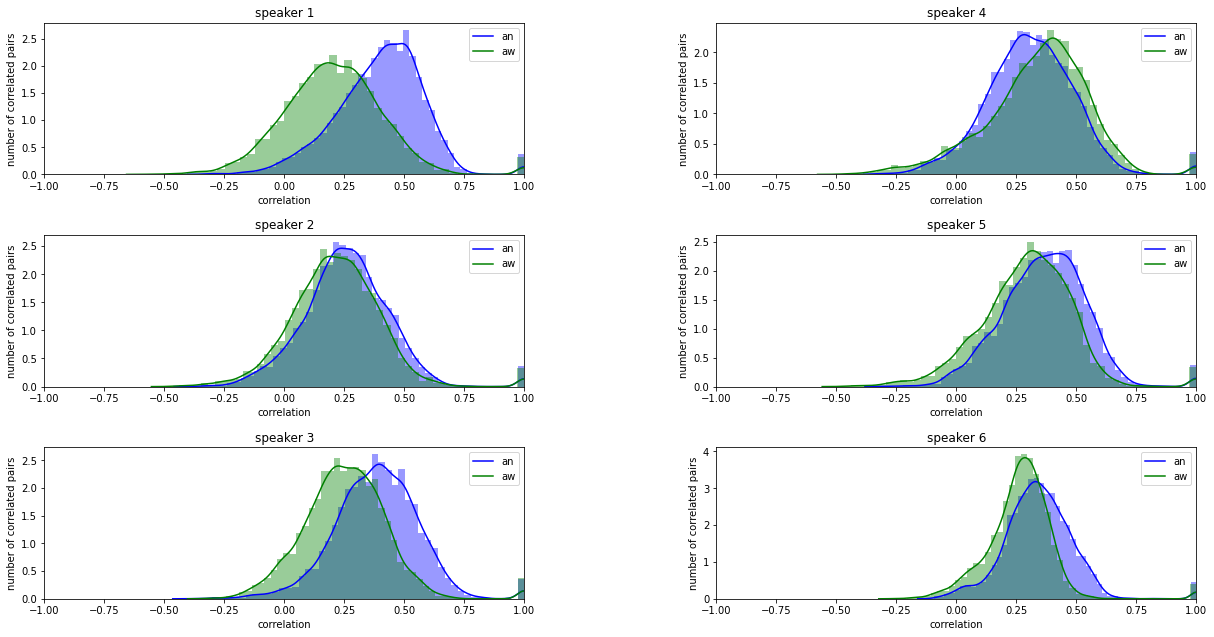

In [16]:
import warnings
warnings.filterwarnings('ignore')

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]

        #plot the correlation distribution
        f, ax = plt.subplots(3,2,figsize=(20, 10))
        for speaker in range(0,6):
            #make dict to convert to dataframe
            if(speaker==5):
                dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)
            else:
                dat_df_an, dat_df_aw = make_dict_one_speaker(dat_sean, dat_seaw, speaker)

            #exclude the rows/columns which index is not in the other dataframe
            df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

            df_an_line = df_corr_an.unstack()
            so1 = df_an_line.sort_values(kind="quicksort")
            df_aw_line = df_corr_aw.unstack()
            so2 = df_aw_line.sort_values(kind="quicksort")

            
            ax[speaker%3][speaker//3].set_xlim([-1, 1])
            ax[speaker%3][speaker//3].set_xlabel('correlation')
            ax[speaker%3][speaker//3].set_ylabel('number of correlated pairs')
            ax[speaker%3][speaker//3].set_title('speaker ' + str(speaker+1))
            
            sns.distplot(so1, hist=True, color="b", ax=ax[speaker%3][speaker//3])
            sns.distplot(so2, hist=True, color="g", ax=ax[speaker%3][speaker//3])
            ax[speaker%3][speaker//3].legend(['an', 'aw'])
            plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
                    
        break
    break

##### Cumulative plot of correlations

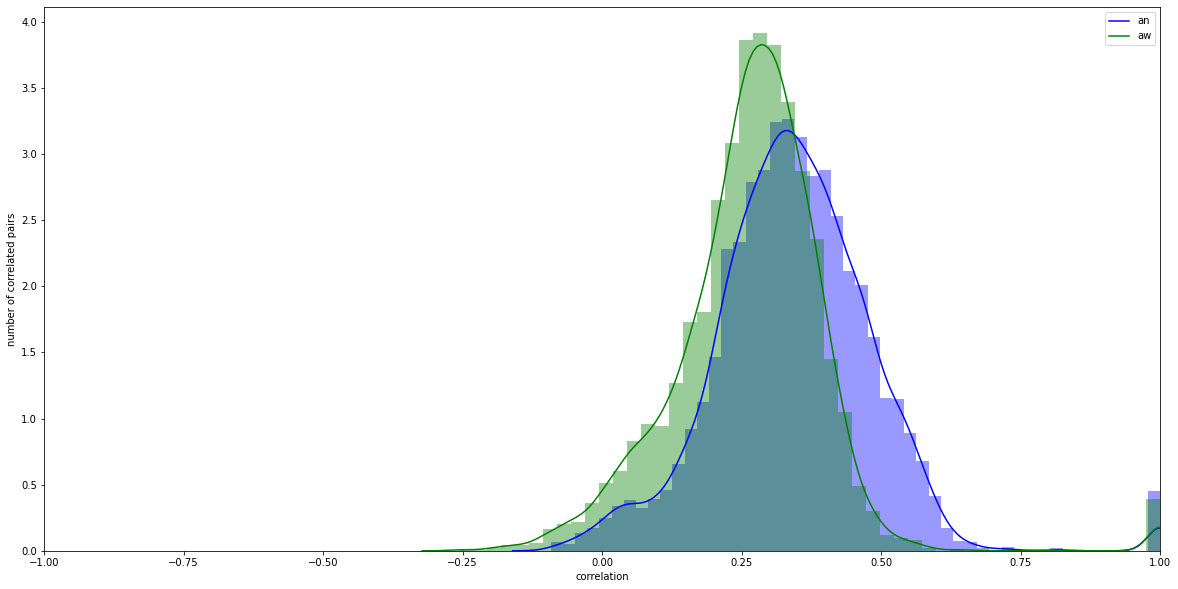

In [12]:
import warnings
warnings.filterwarnings('ignore')

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        df_an_line = df_corr_an.unstack()
        so1 = df_an_line.sort_values(kind="quicksort")
        df_aw_line = df_corr_aw.unstack()
        so2 = df_aw_line.sort_values(kind="quicksort")

        #plot the correlation distribution
        f, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim([-1, 1])
        ax.set_xlabel('correlation')
        ax.set_ylabel('number of correlated pairs')
        
        sns.distplot(so1, hist=True, color="b")
        sns.distplot(so2, hist=True, color="g")
        ax.legend(['an', 'aw'])

        break
    break

##### Correlation matrix of All ROI positions 

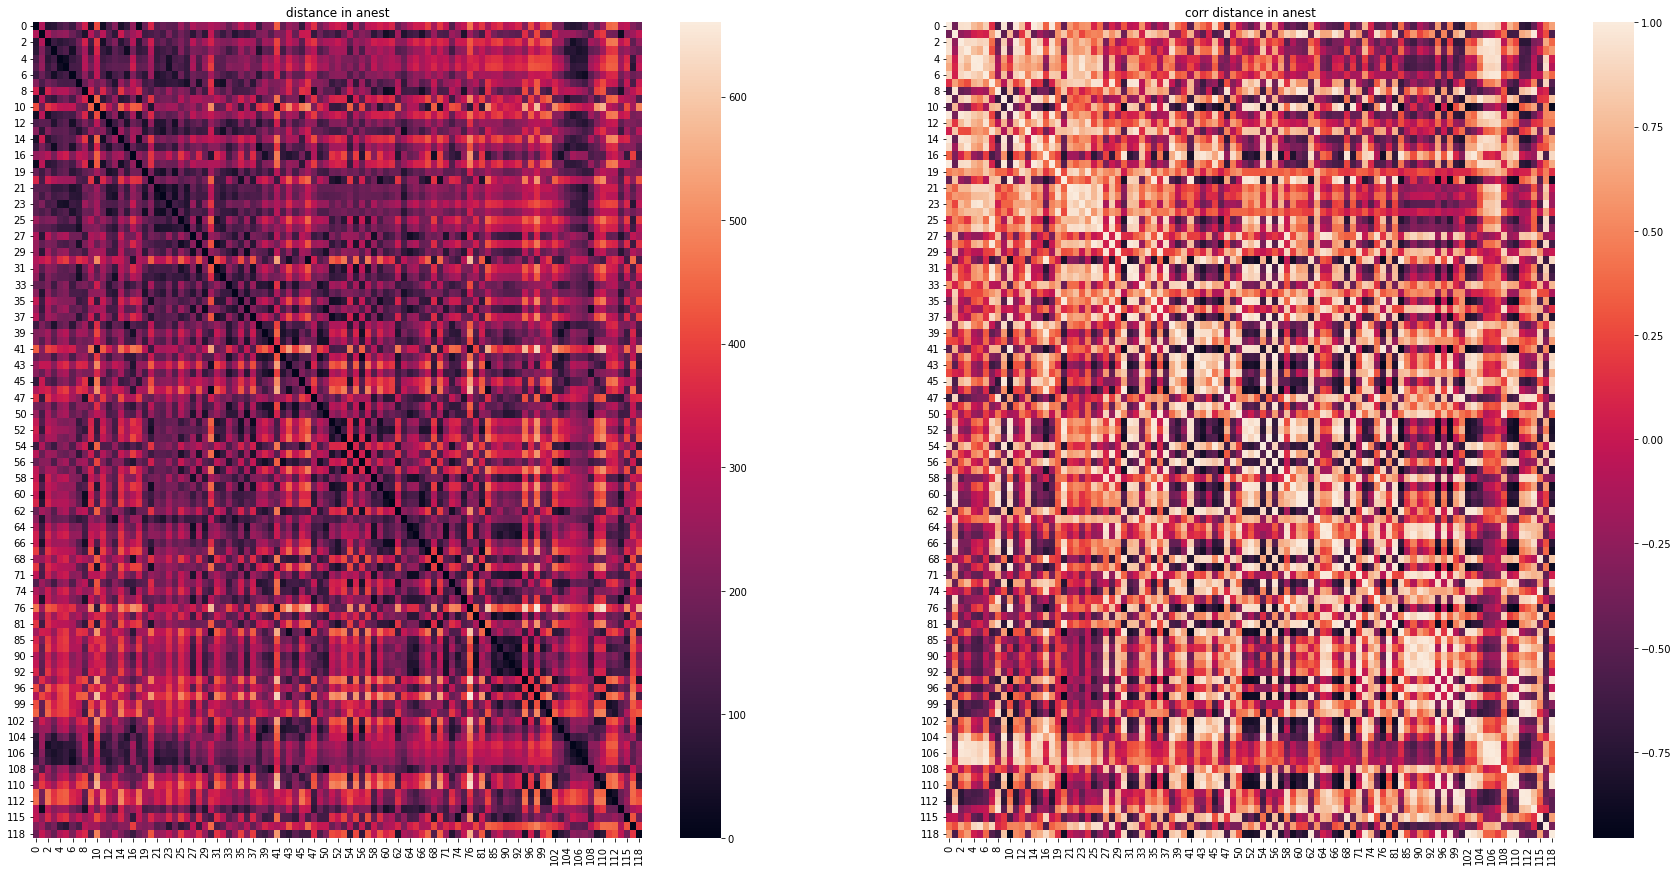

In [13]:
#distances in awake and anestatized state are simmilar, so the plot shows only the anestatized state

#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    pos_tr = roi_load[index[trial-1] : index[trial]+1, :, :, :]

    #choose state
    pos_stan = pos_tr[:, :, 0, :]
    pos_staw = pos_tr[:, :, 1, :]
    
    for sesion in range(4):

        f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(30, 15))

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        pos_sean = pos_stan[:, :, sesion]
        pos_seaw = pos_staw[:, :, sesion]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        df_corr_an_pos = pd.DataFrame(index=df_corr_an.index, columns=df_corr_an.columns)
        
        for i in df_corr_an.index:
            for j in df_corr_an.columns:
                df_corr_an_pos.loc[i, j] = np.sqrt((pos_sean[i, 0]-pos_sean[j,0])**2 + (pos_sean[i, 1]-pos_sean[j,1])**2)

        df_corr_an_pos = pd.DataFrame(df_corr_an_pos, index=None).astype(float)
        df_corr_an_pos1 = df_corr_an_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

        ax1.set_title('distance in anest')
        ax2.set_title('corr distance in anest')

        #plot the correlation matrix
        sns.heatmap(df_corr_an_pos, ax=ax1)
        sns.heatmap(df_corr_an_pos1, ax=ax2)

        break
    break
    

##### Plot of correlations and positions 

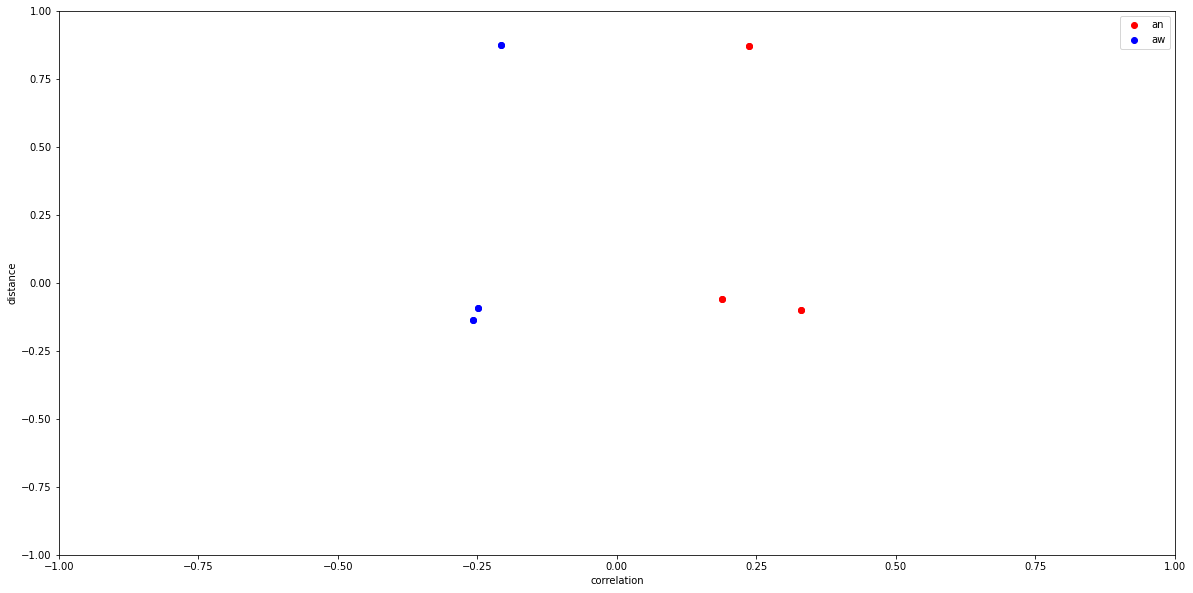

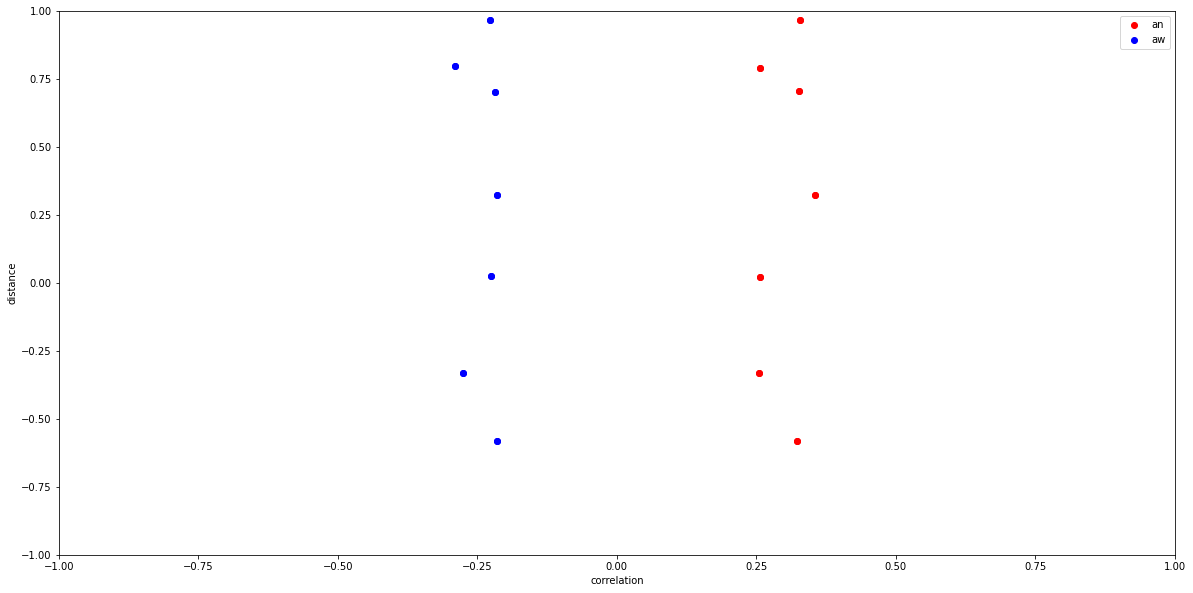

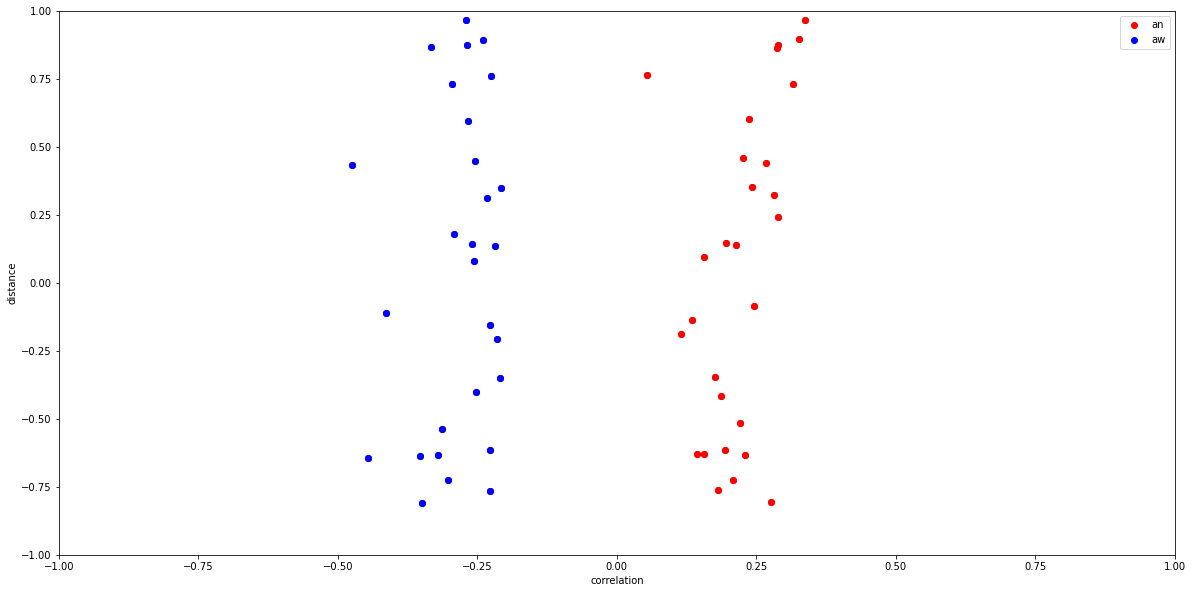

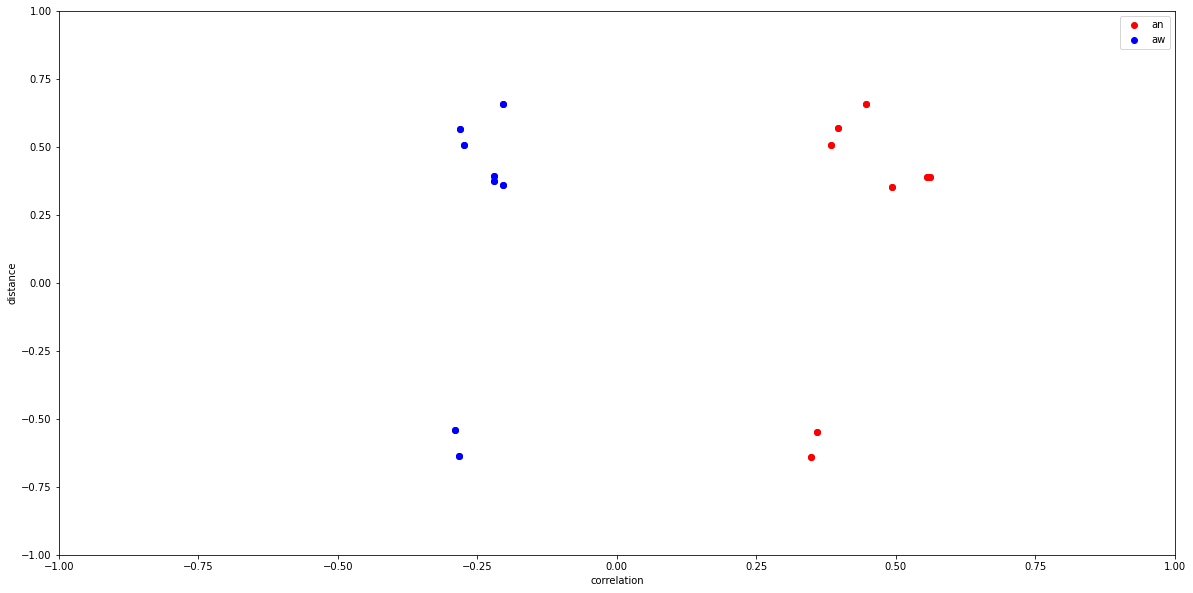

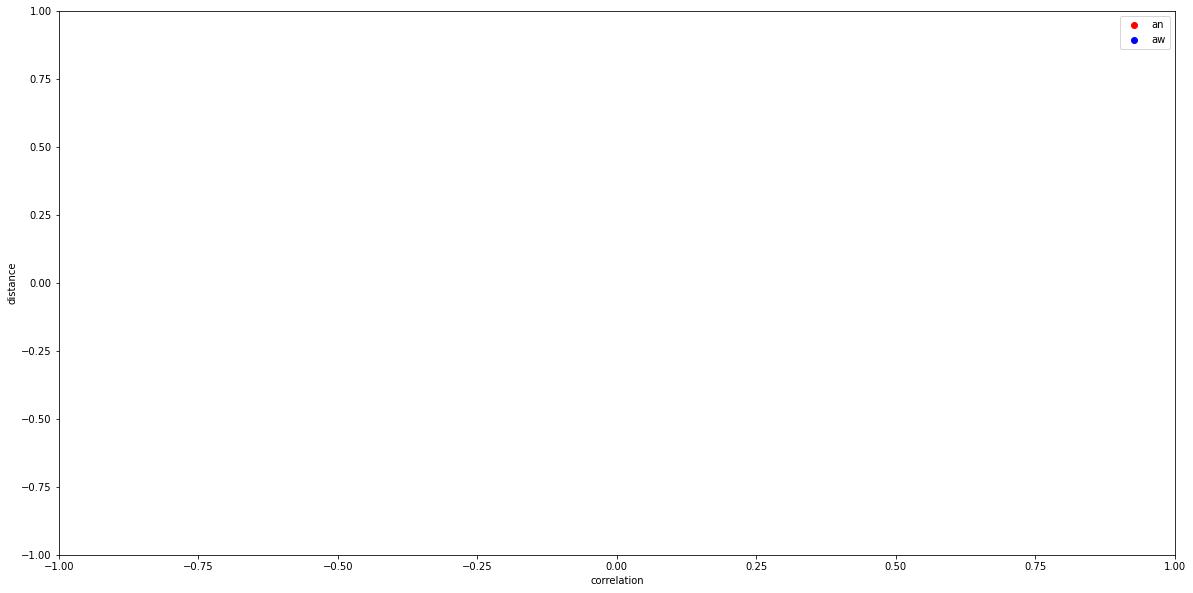

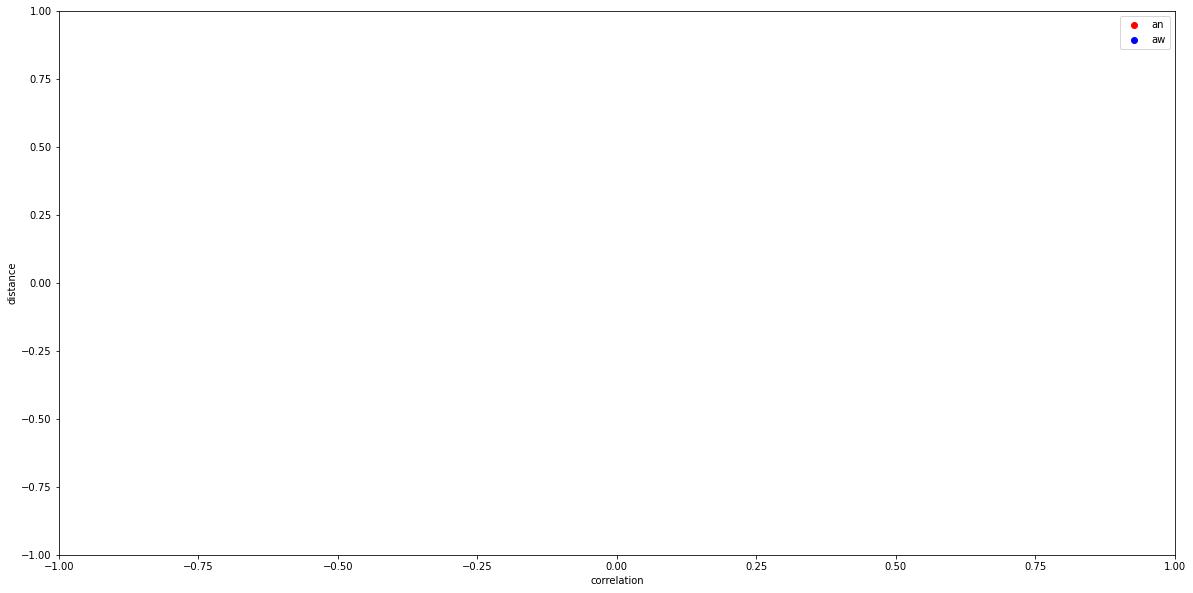

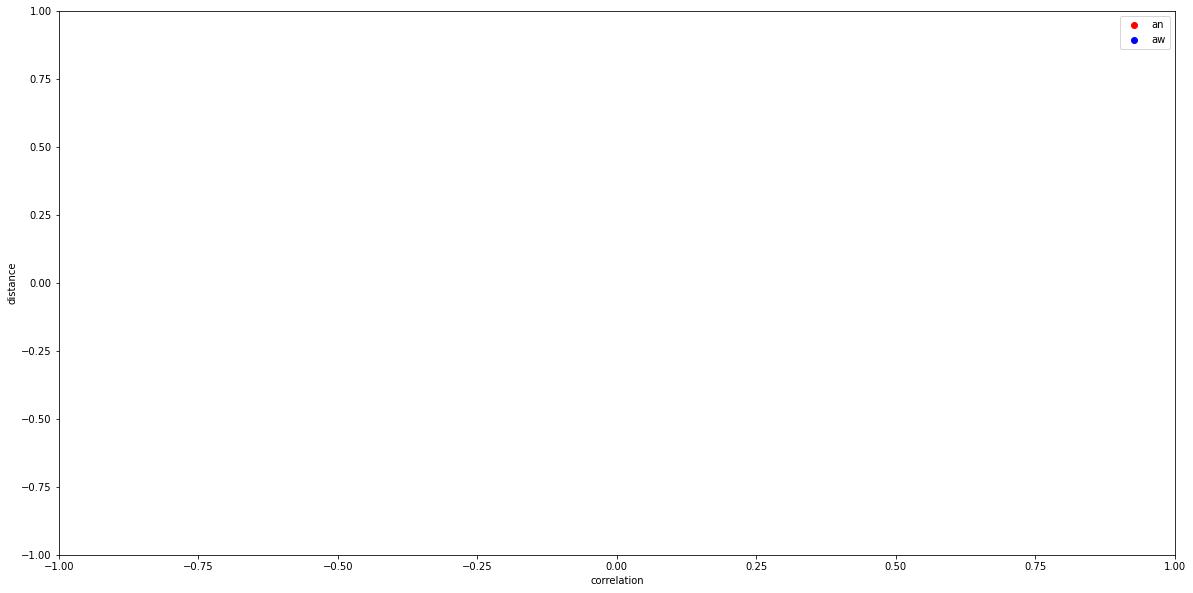

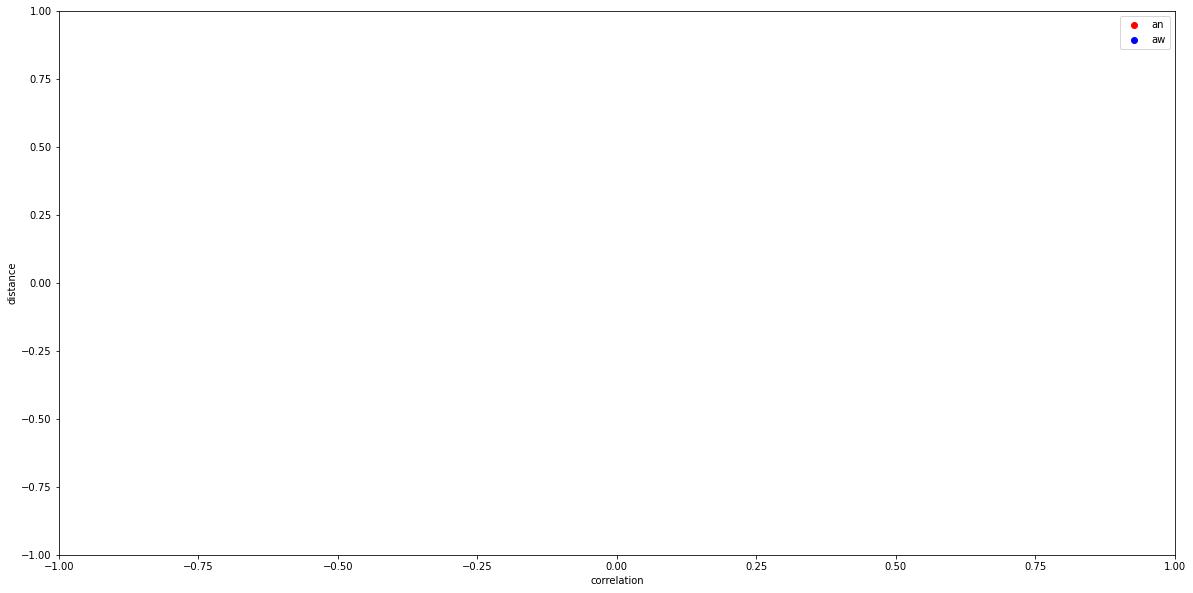

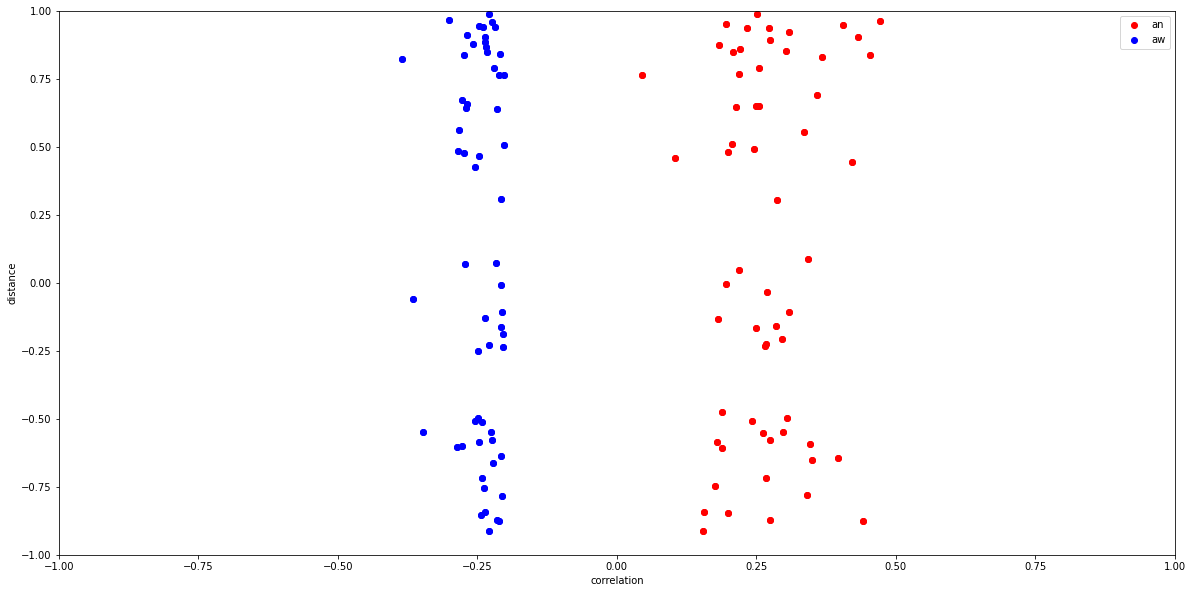

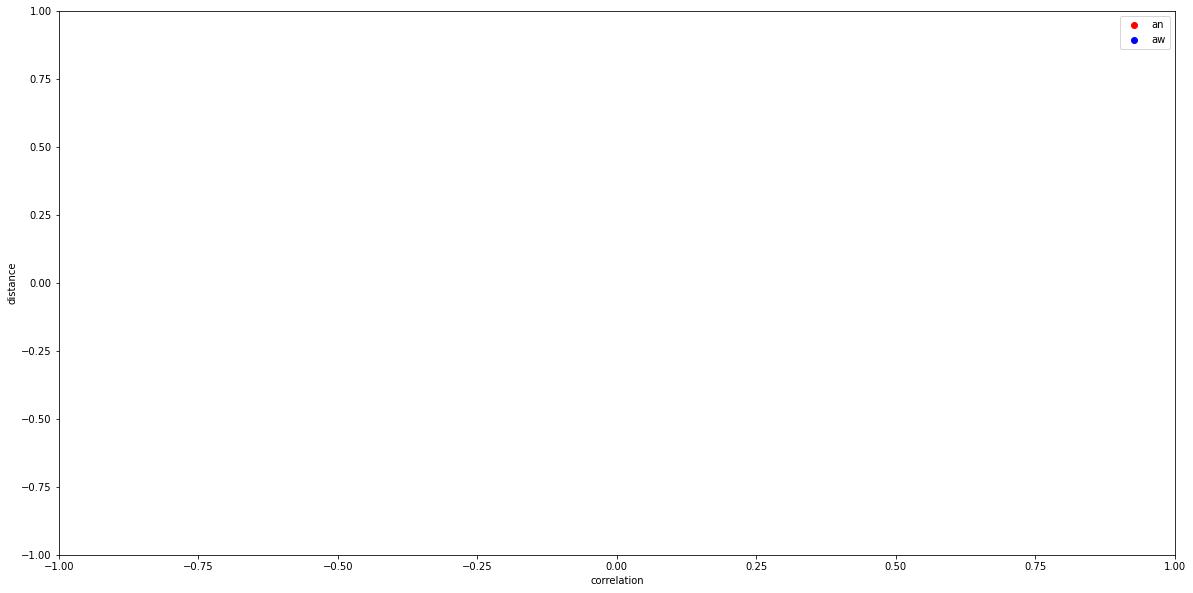

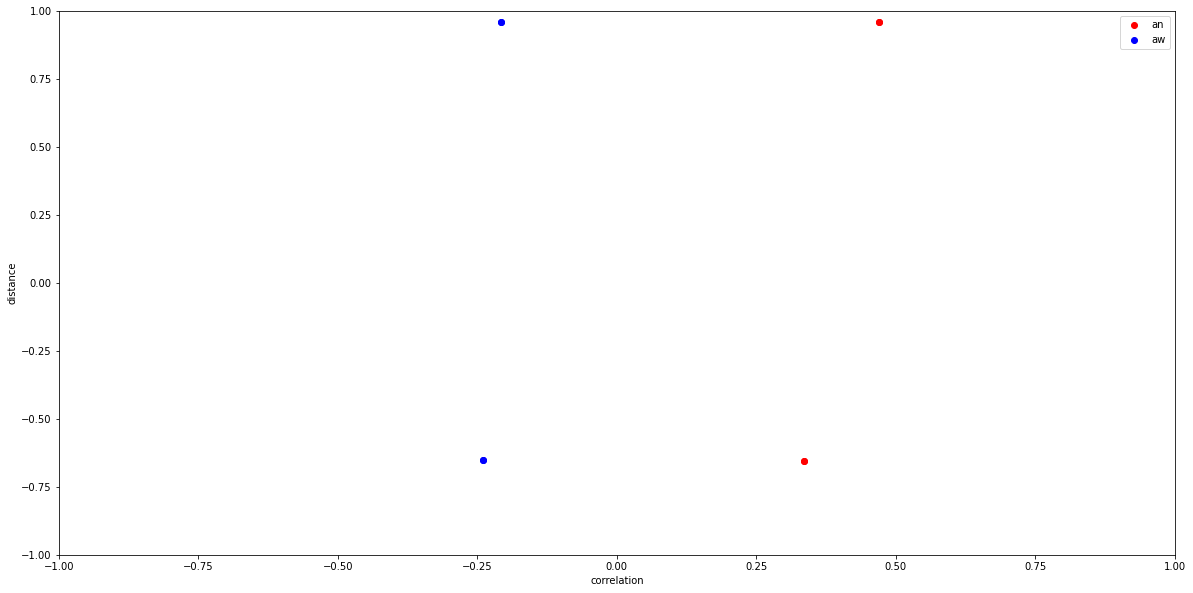

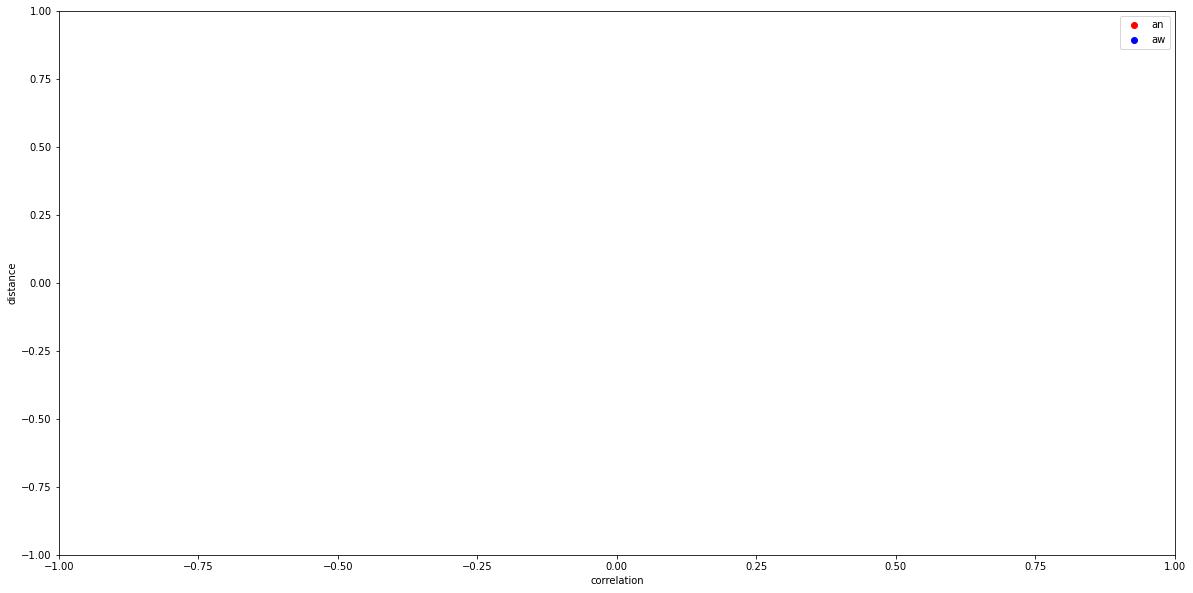

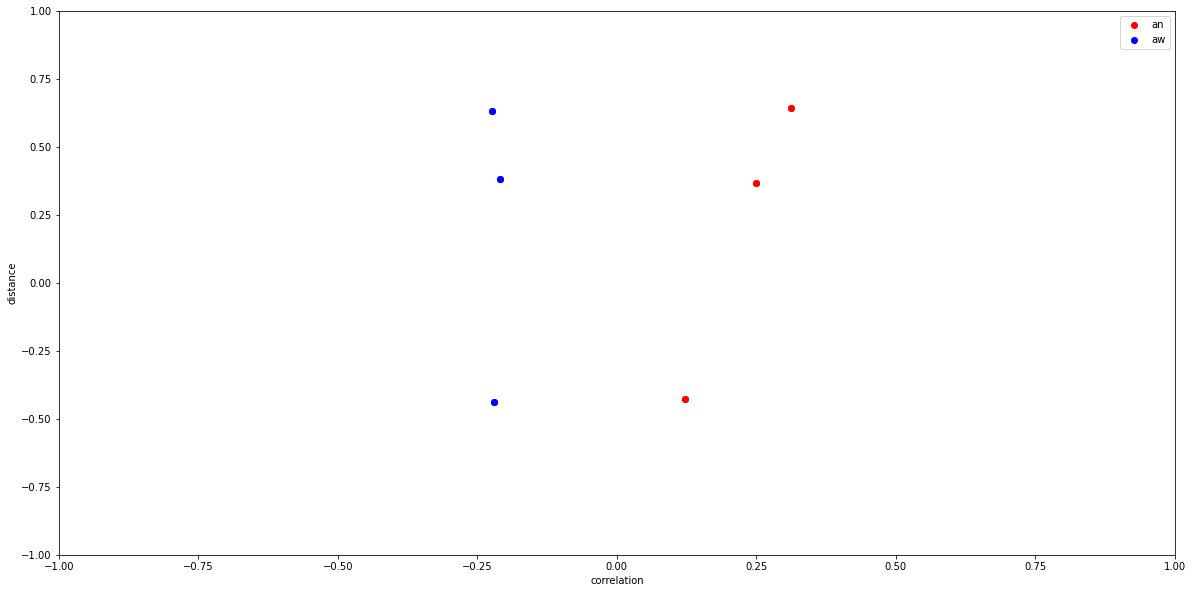

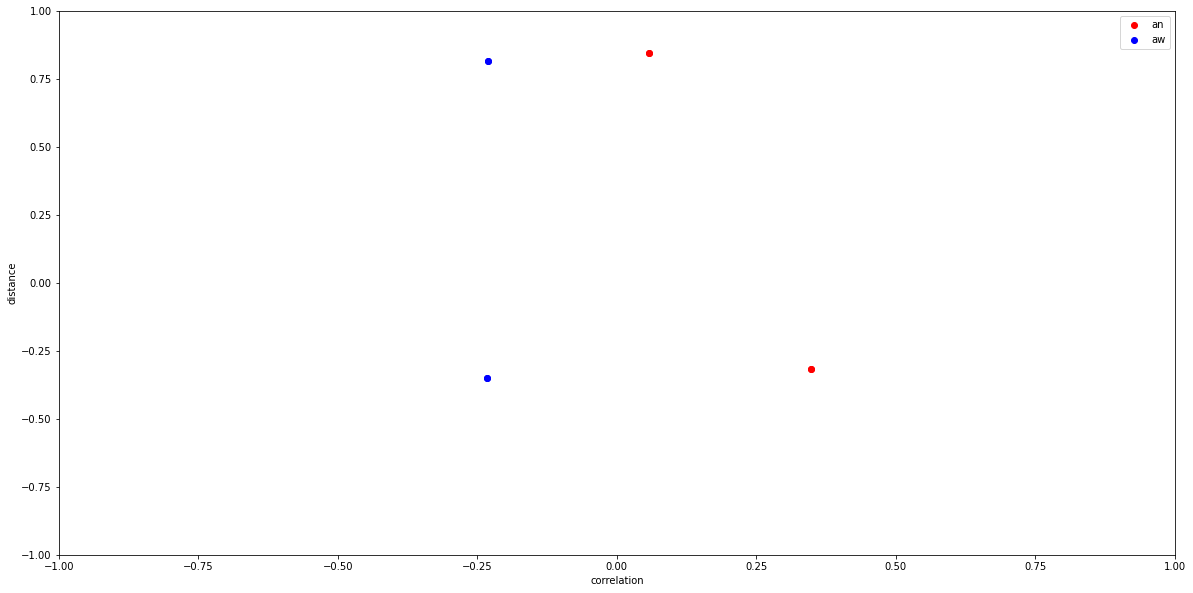

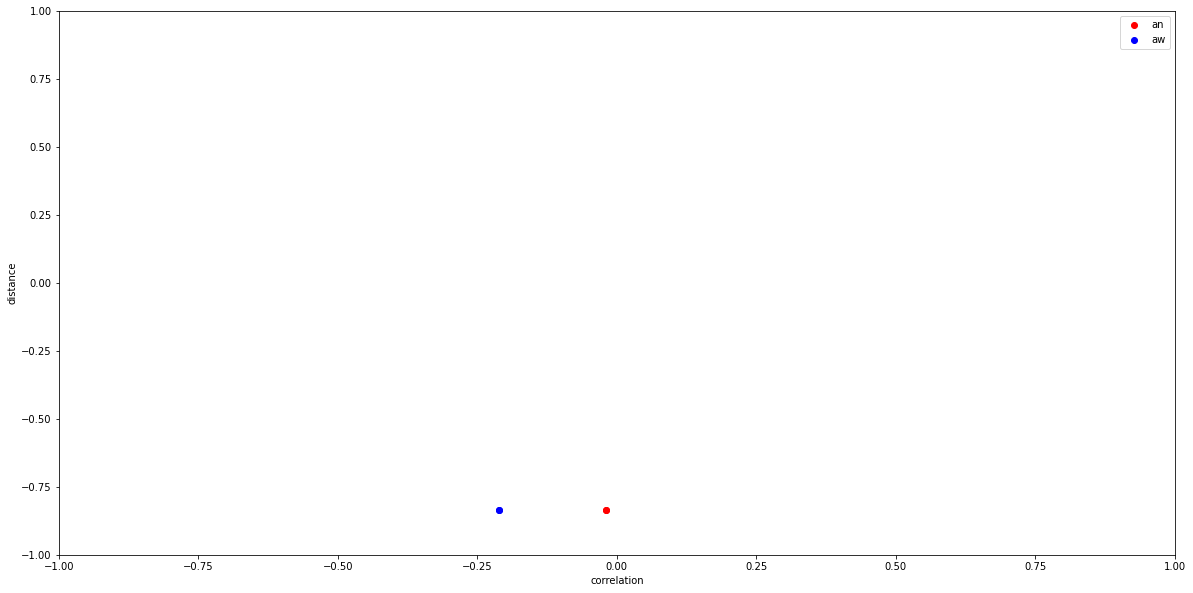

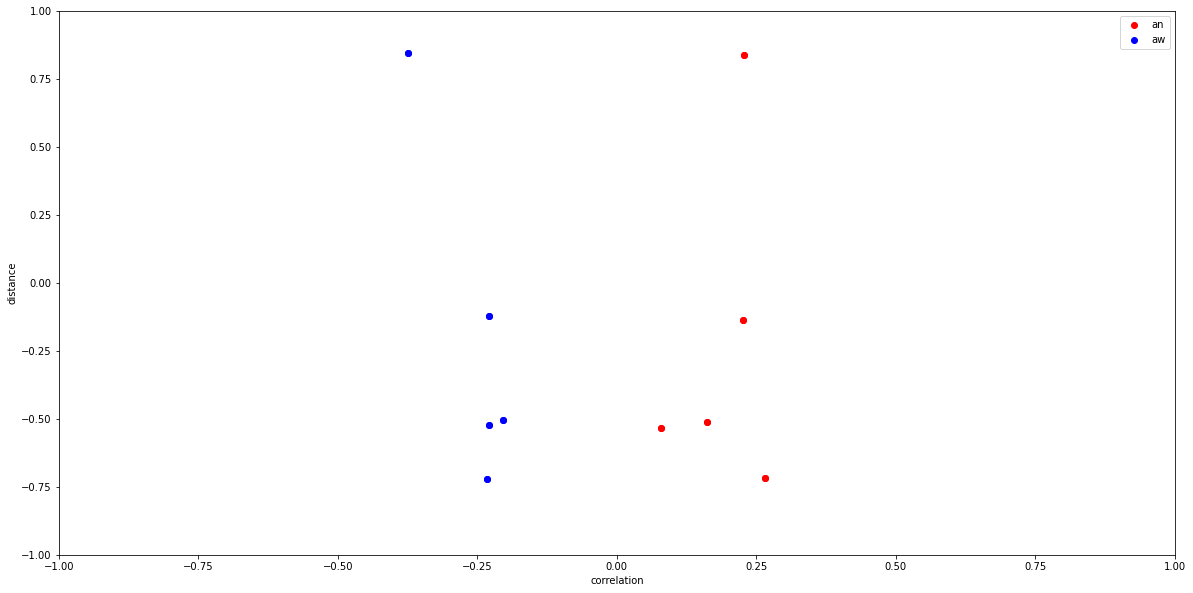

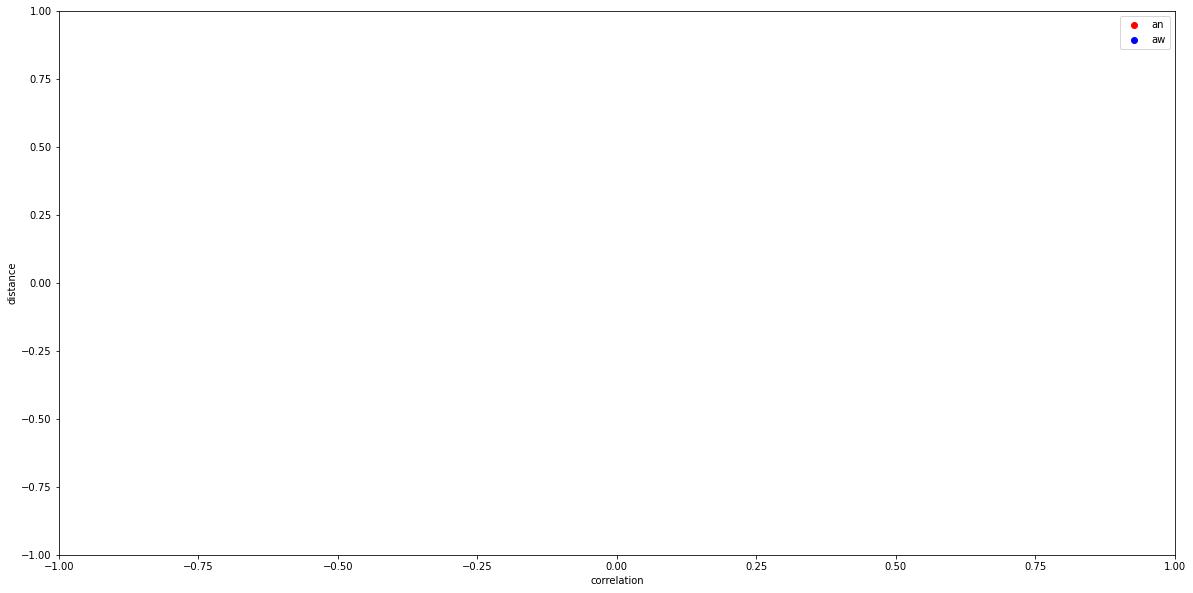

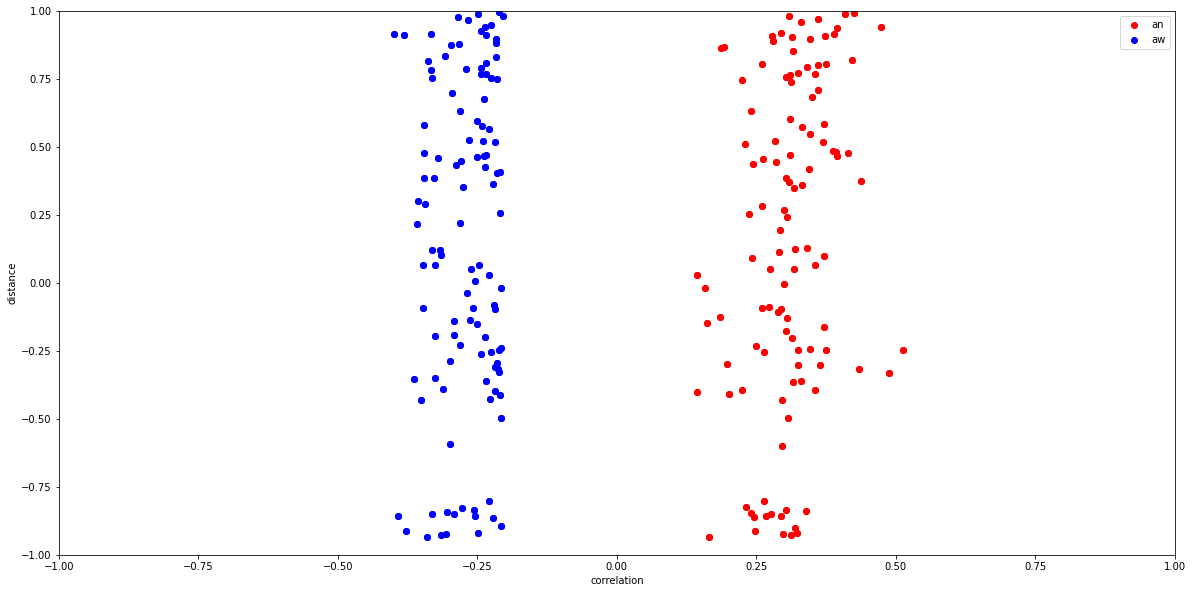

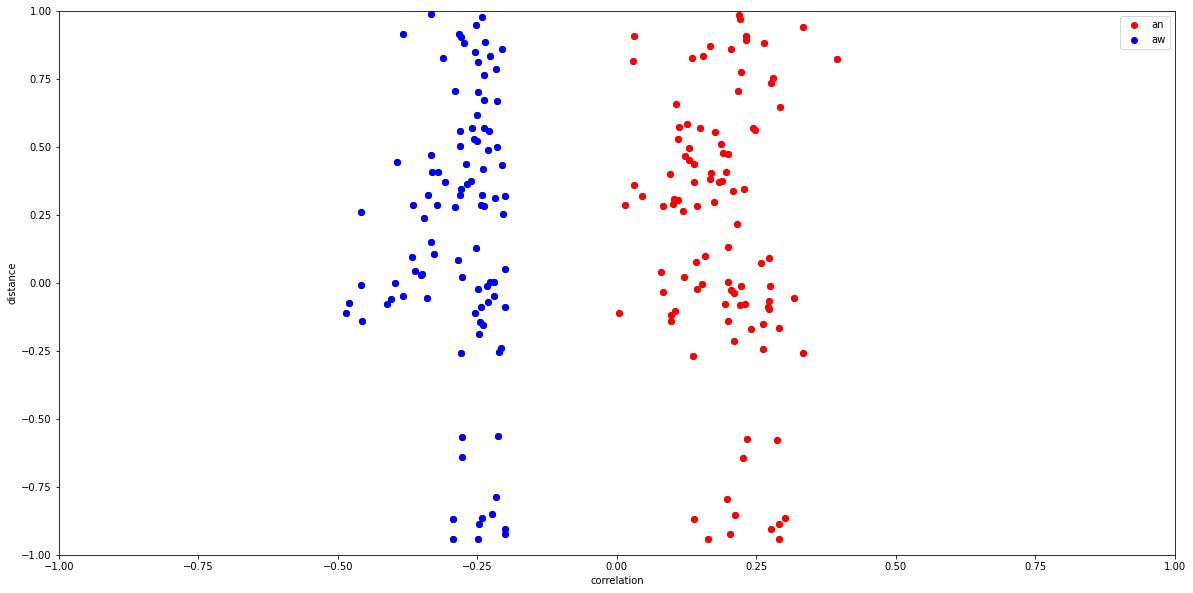

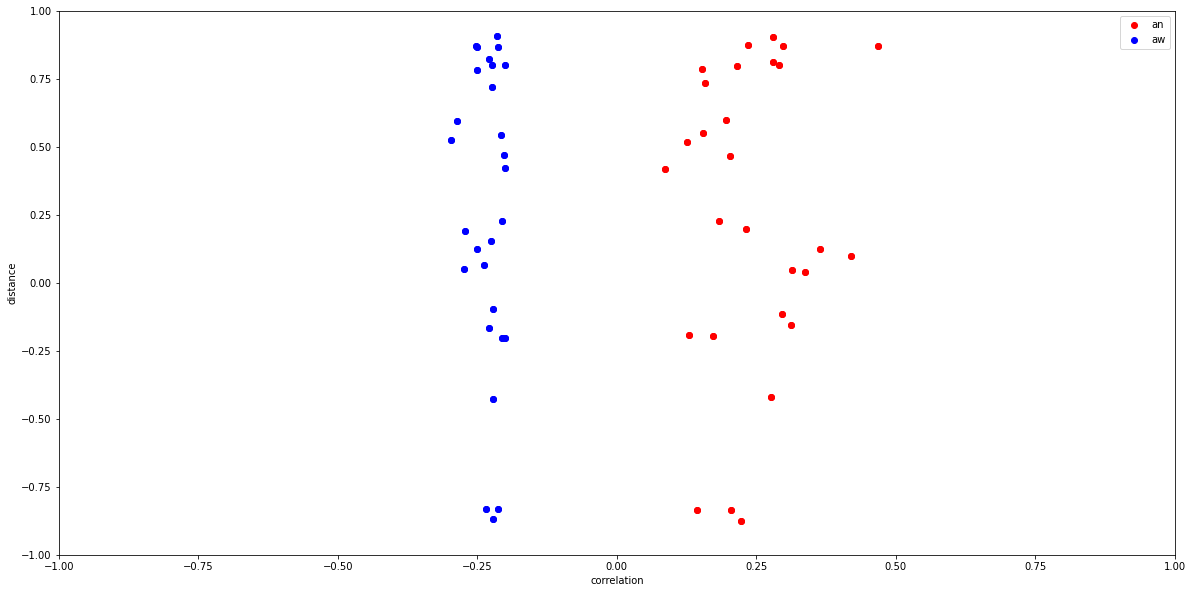

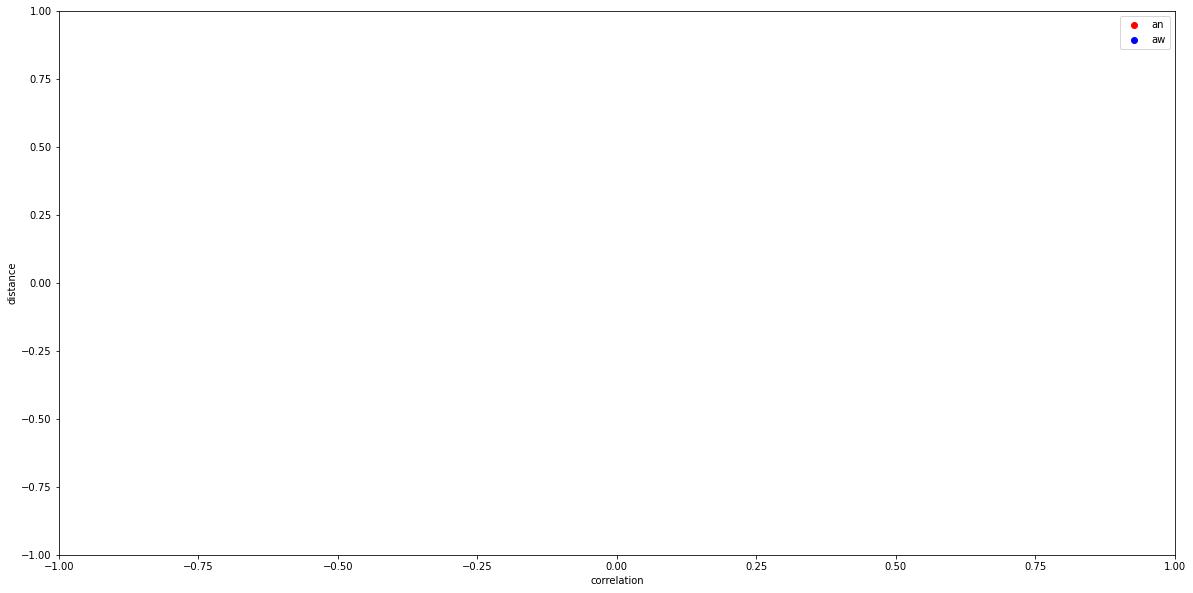

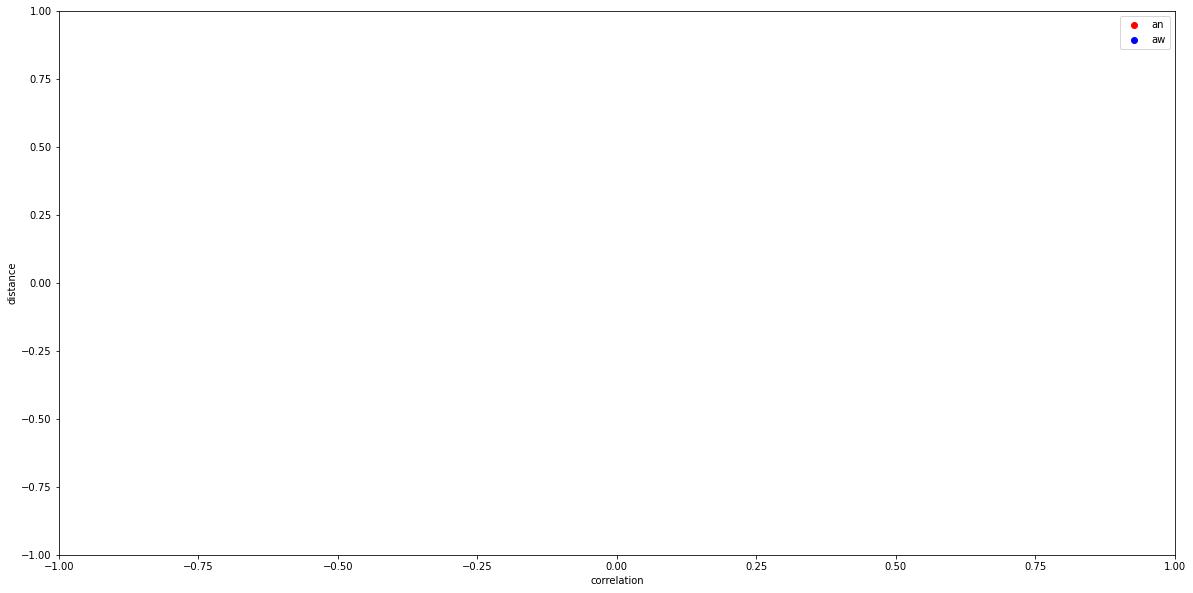

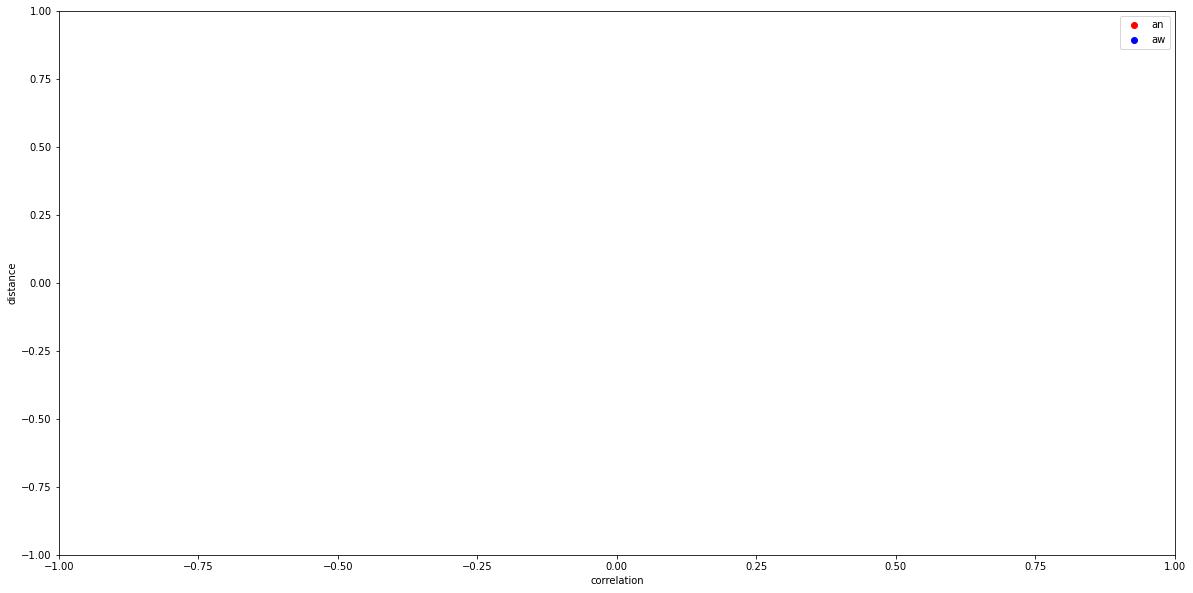

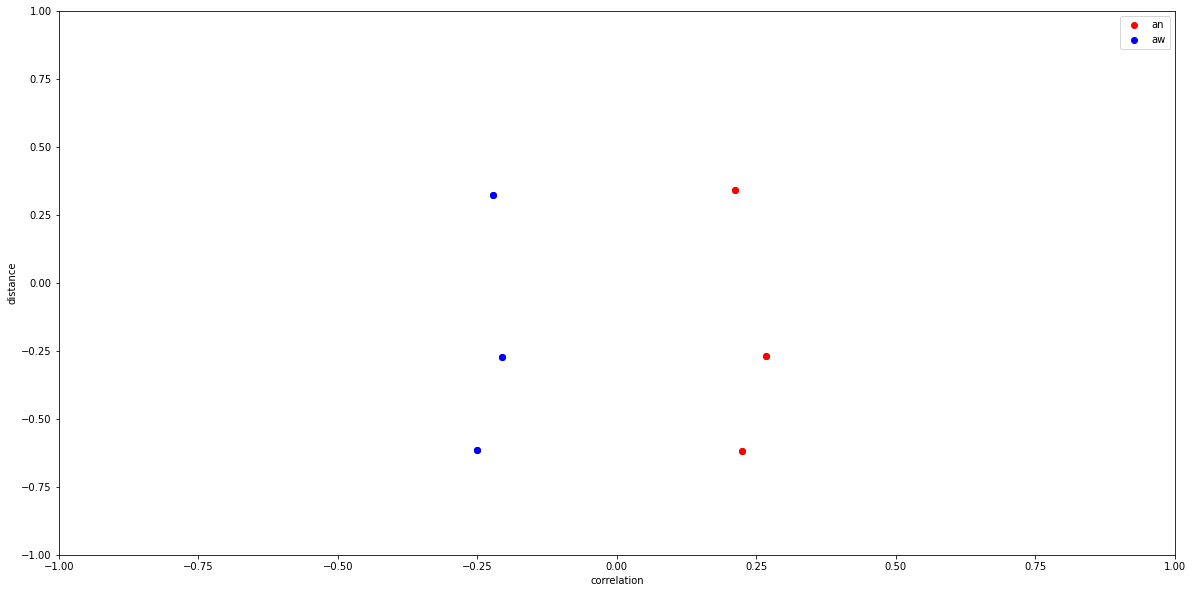

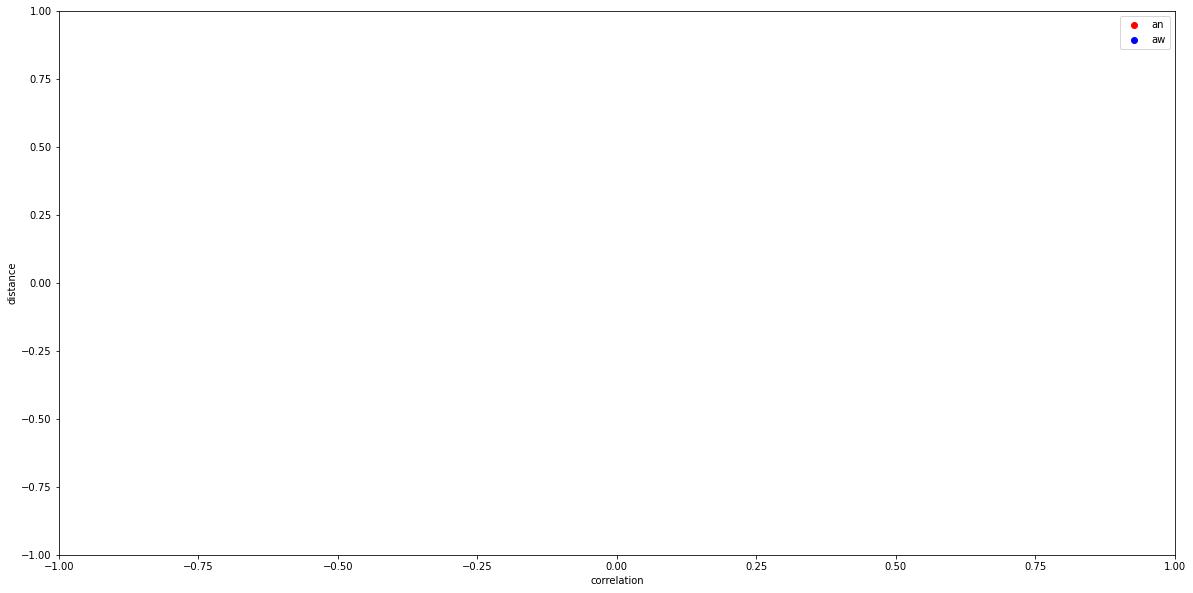

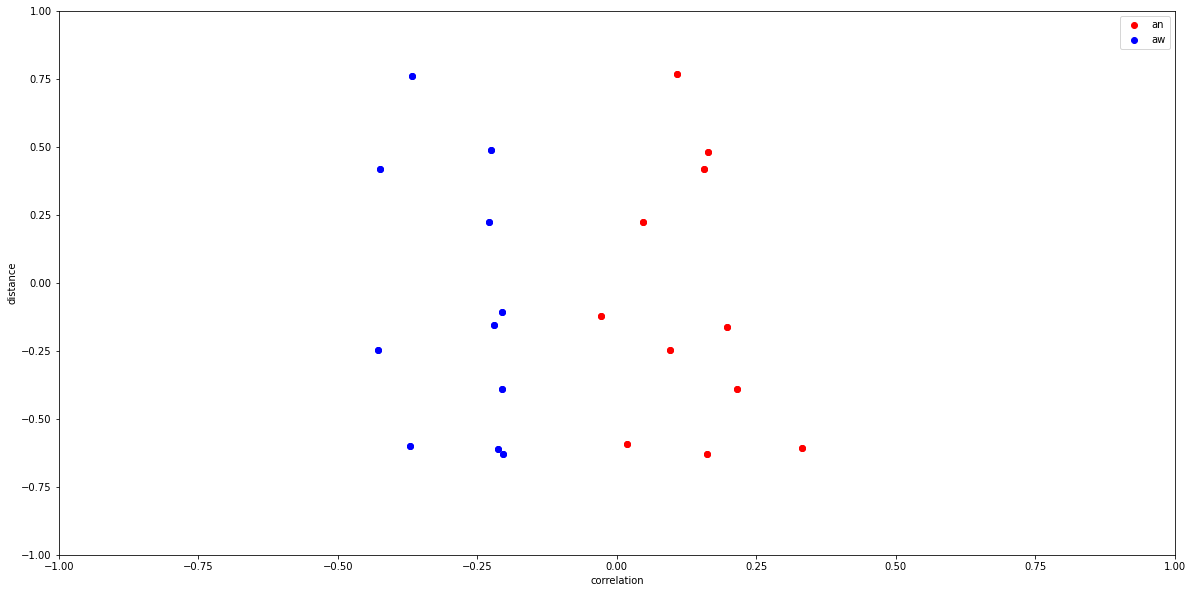

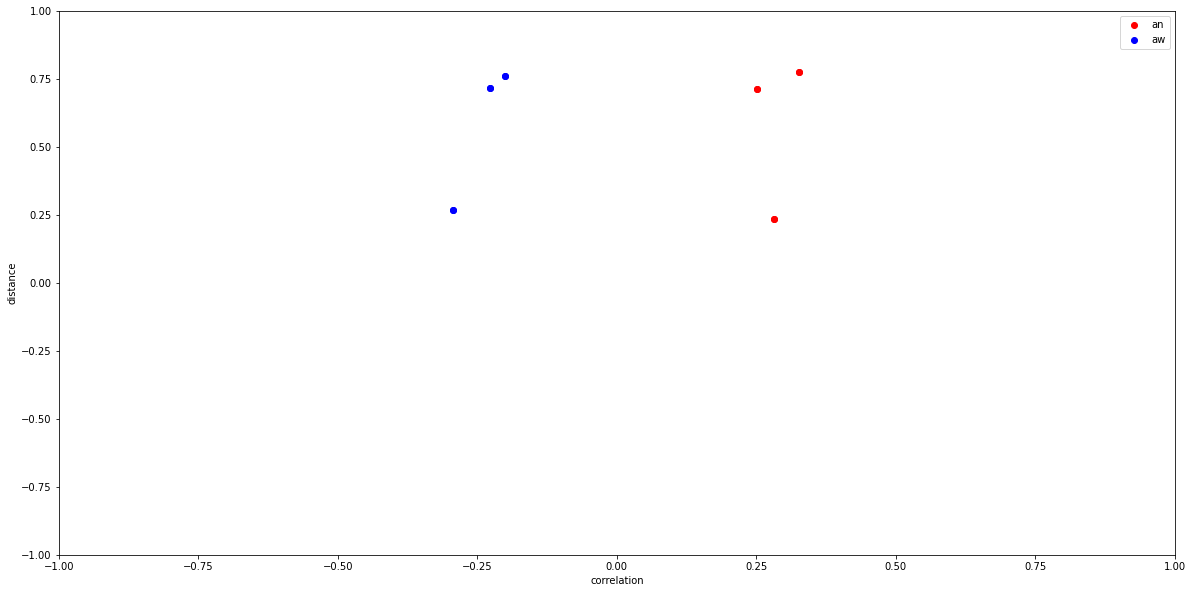

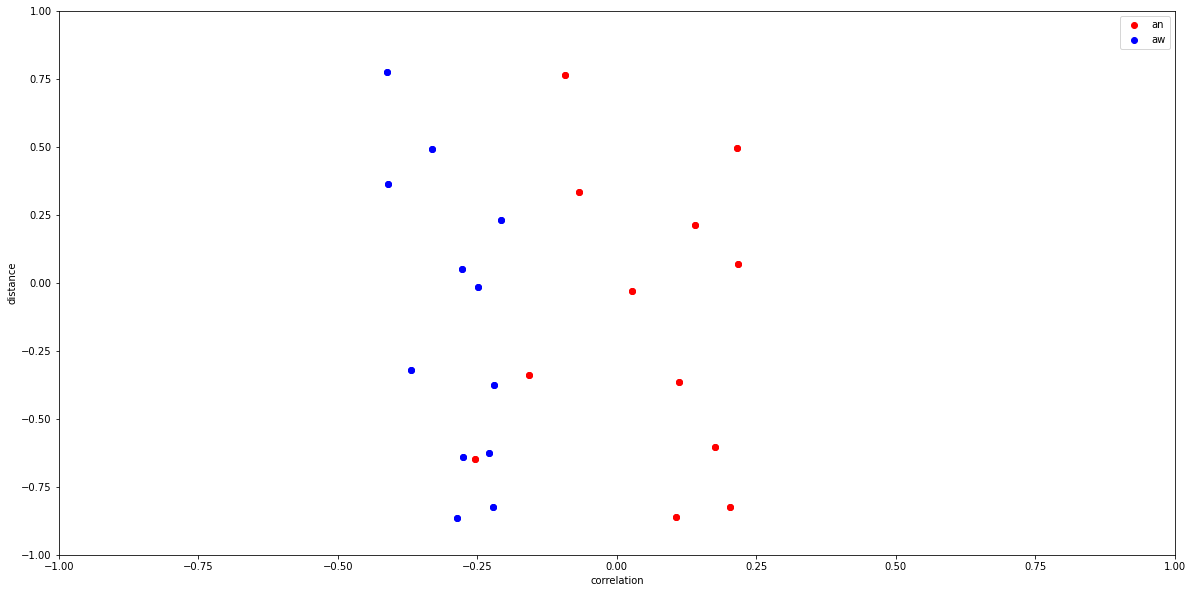

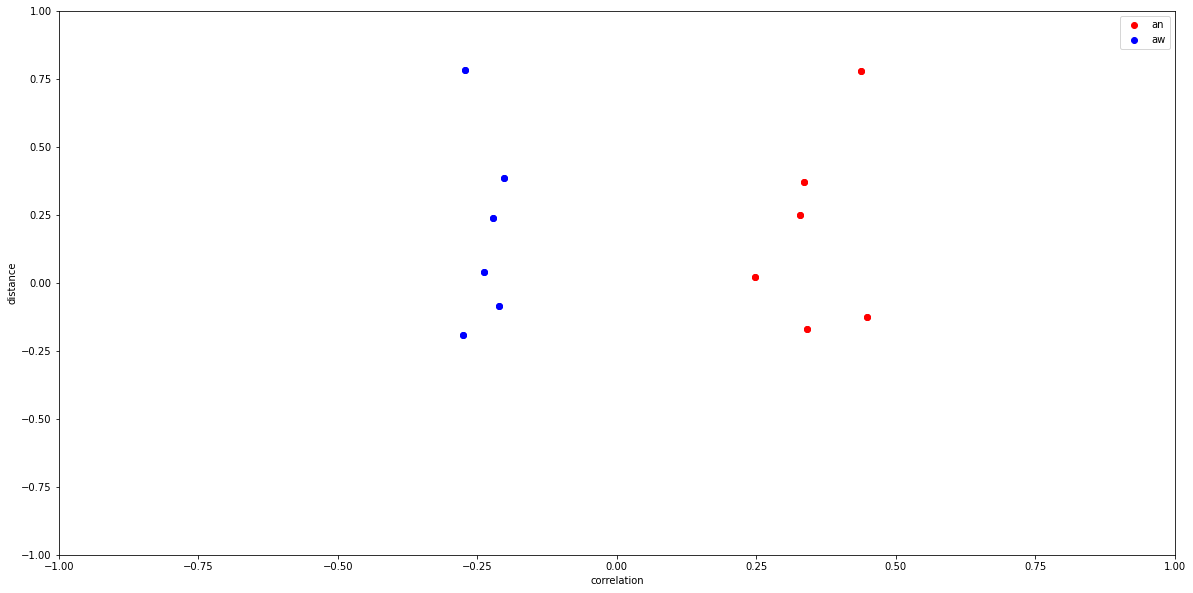

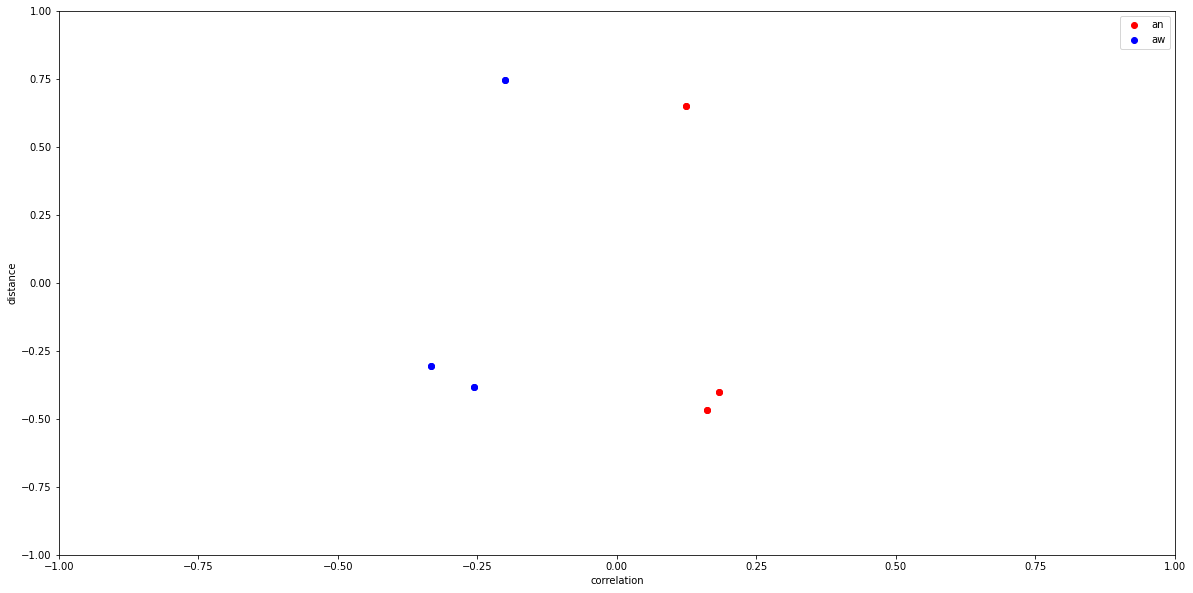

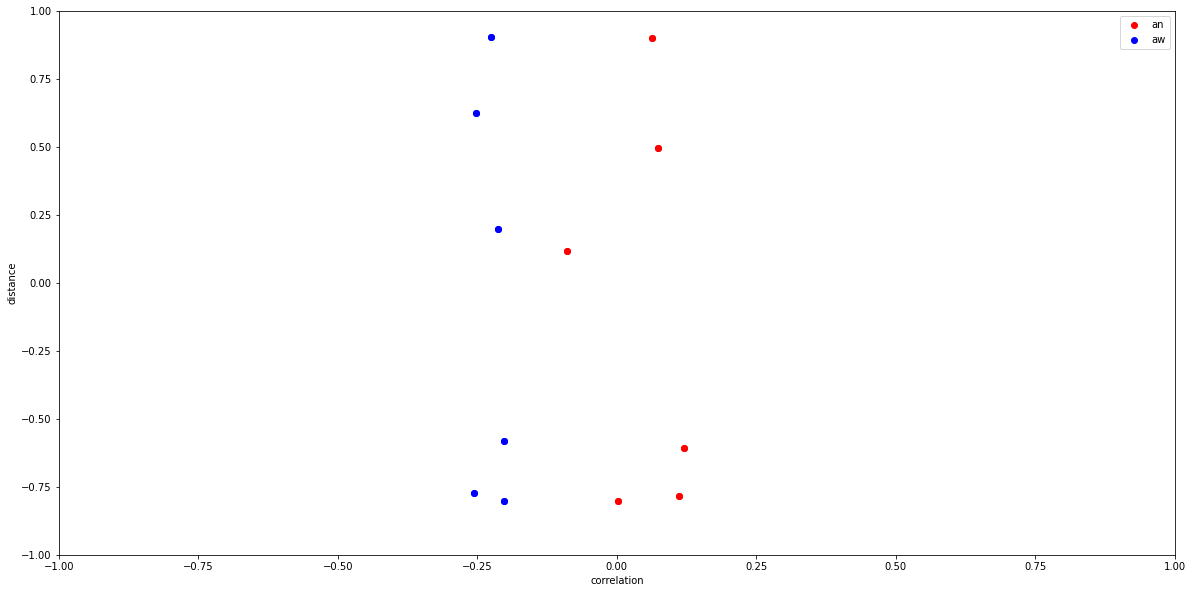

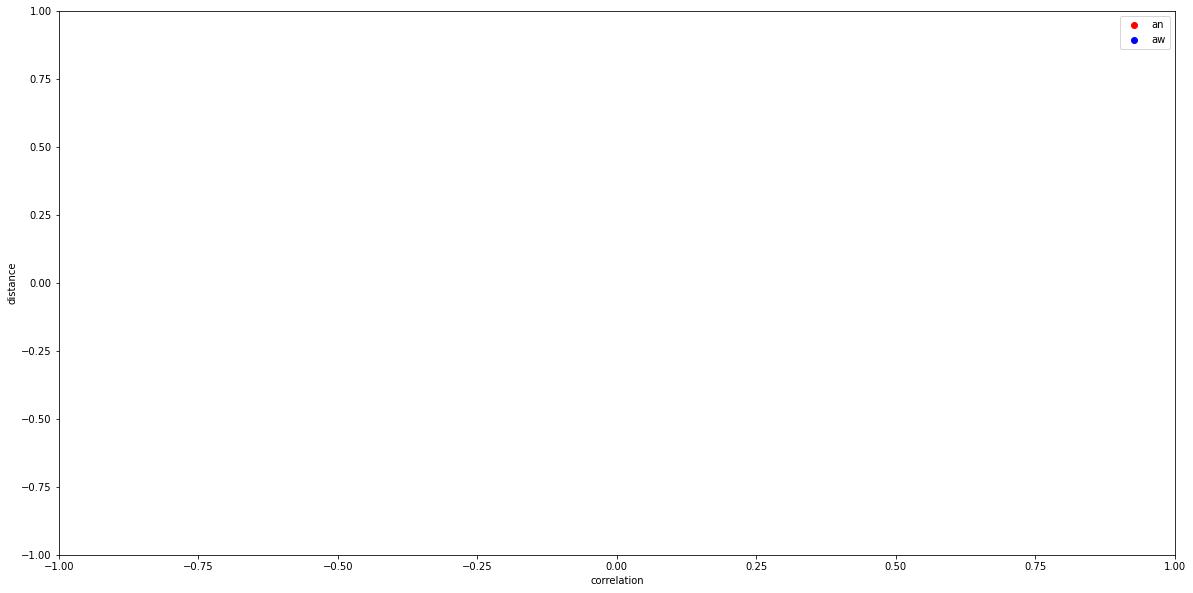

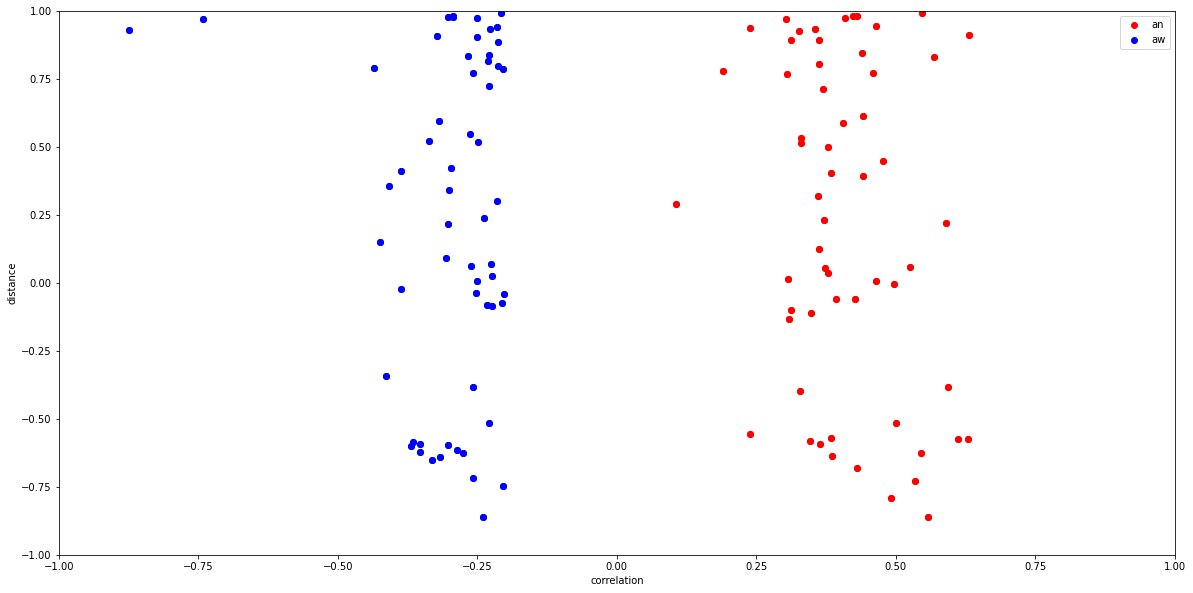

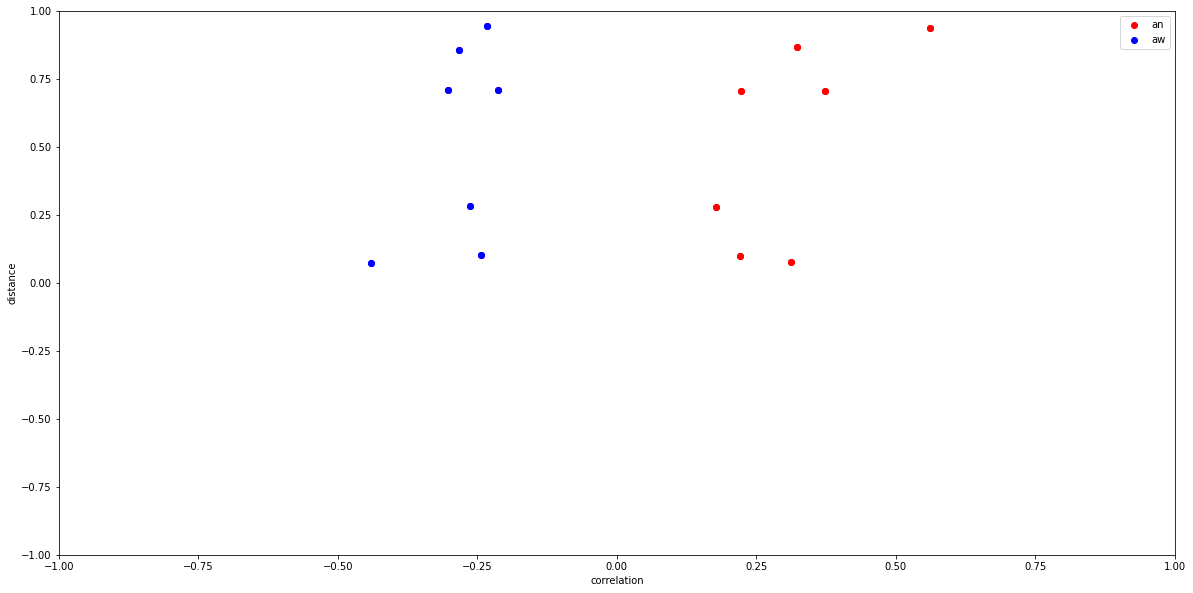

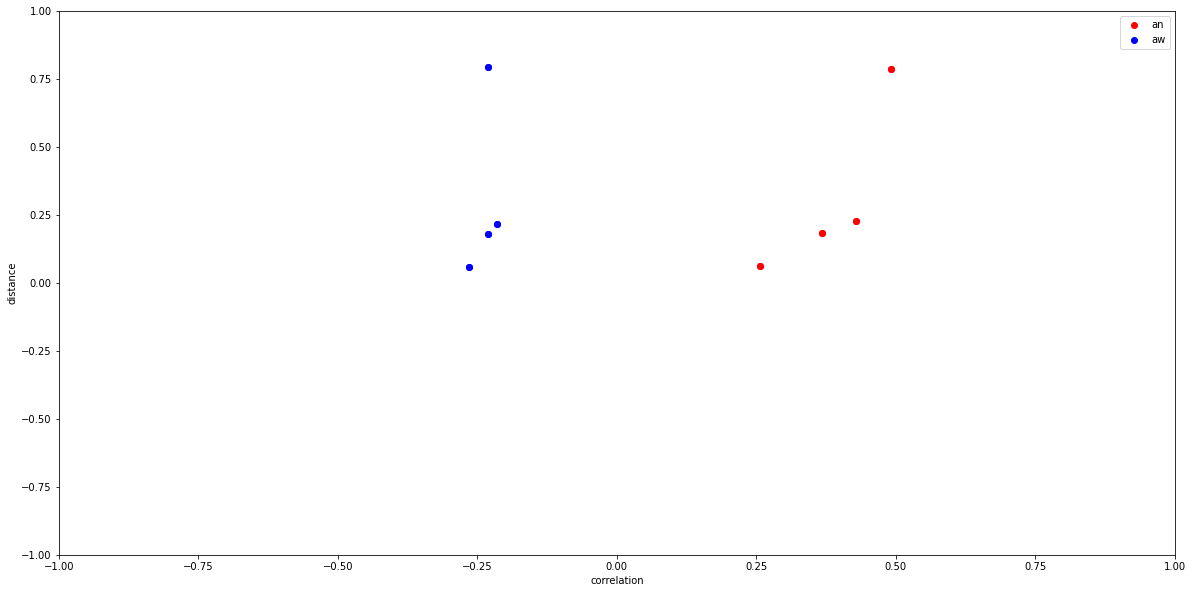

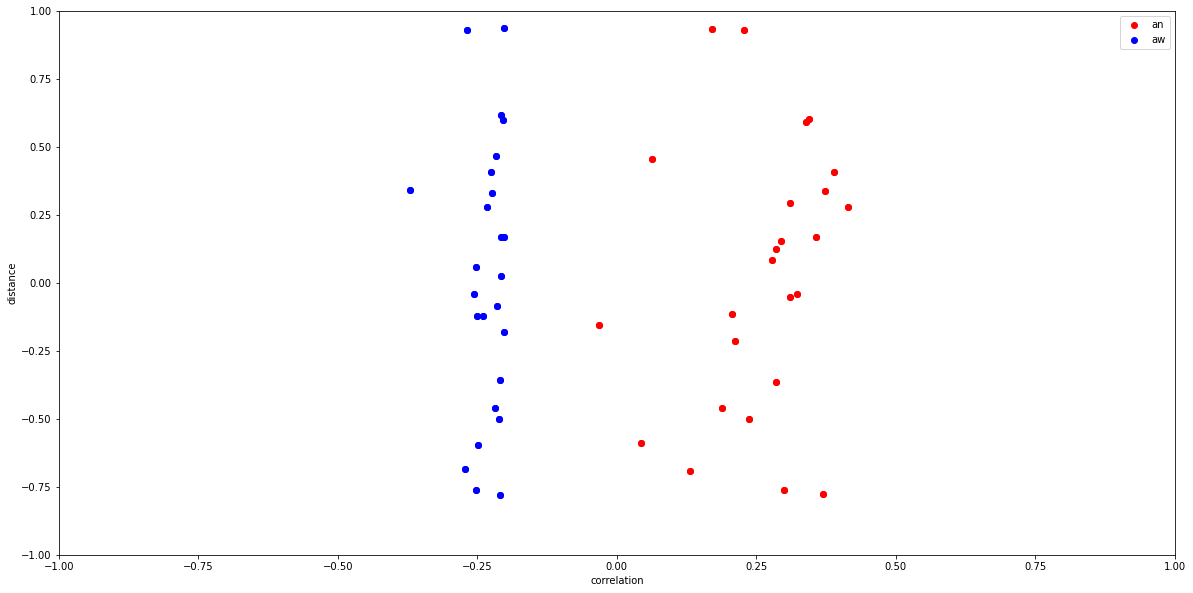

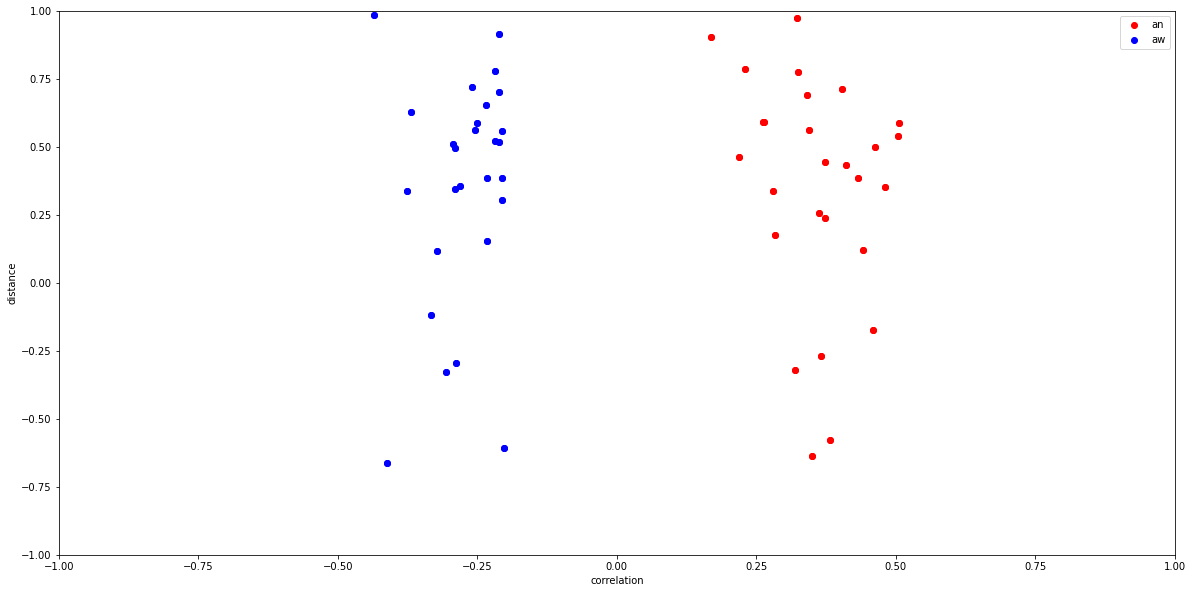

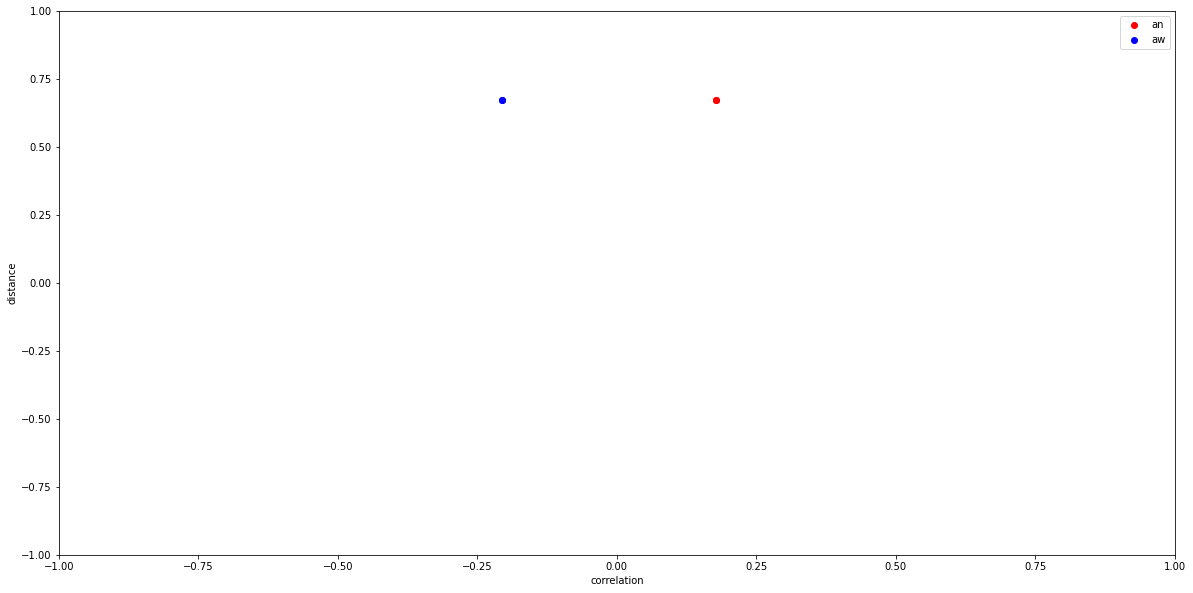

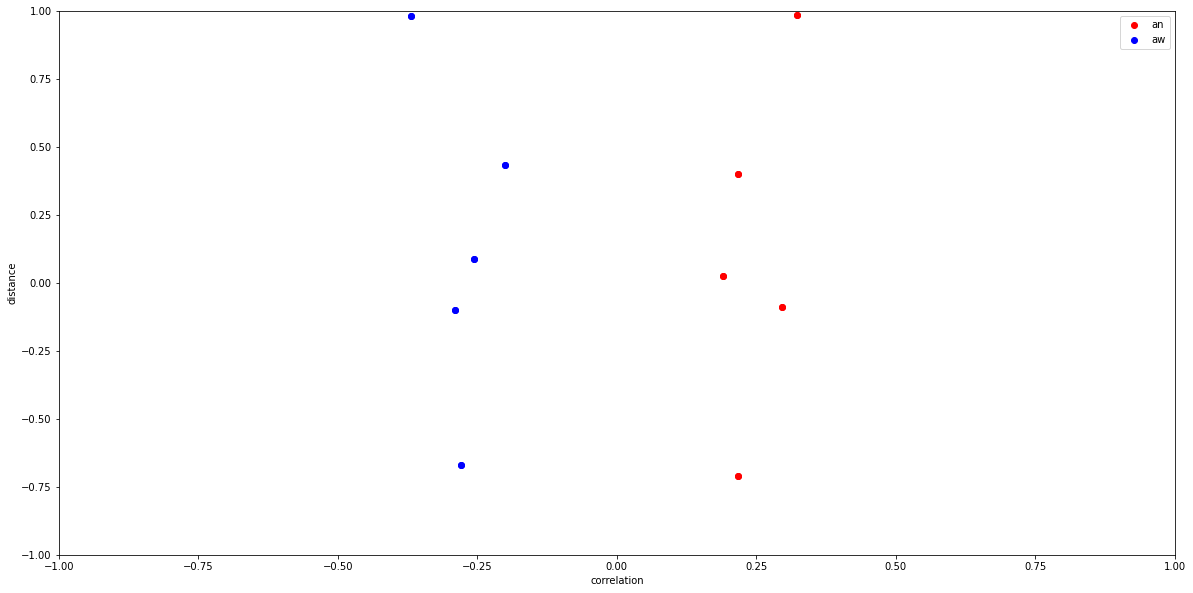

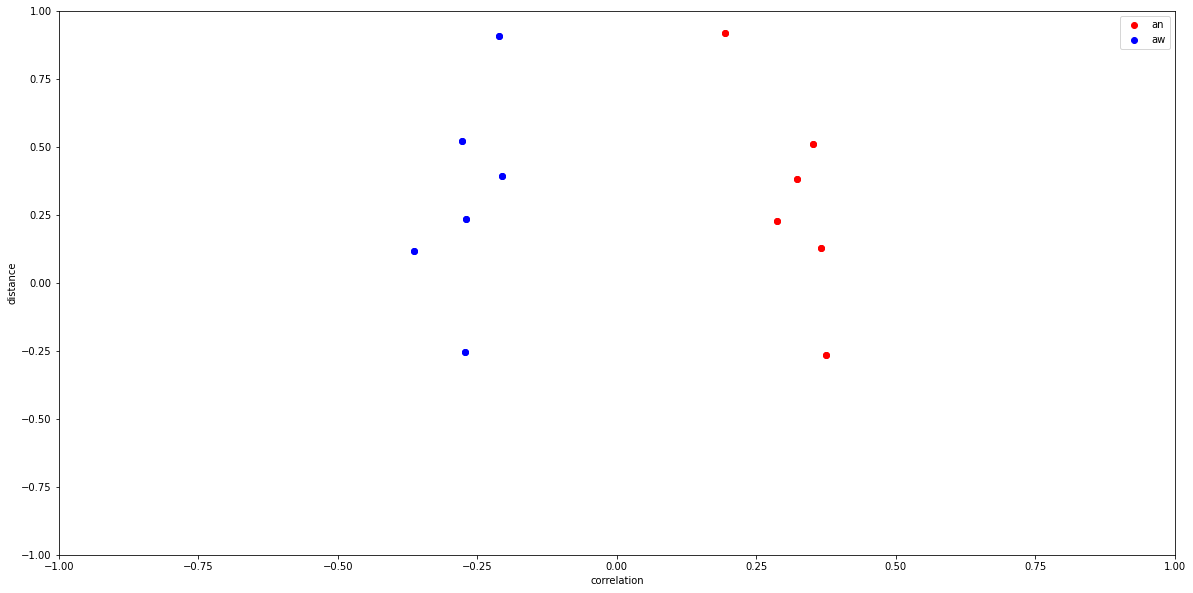

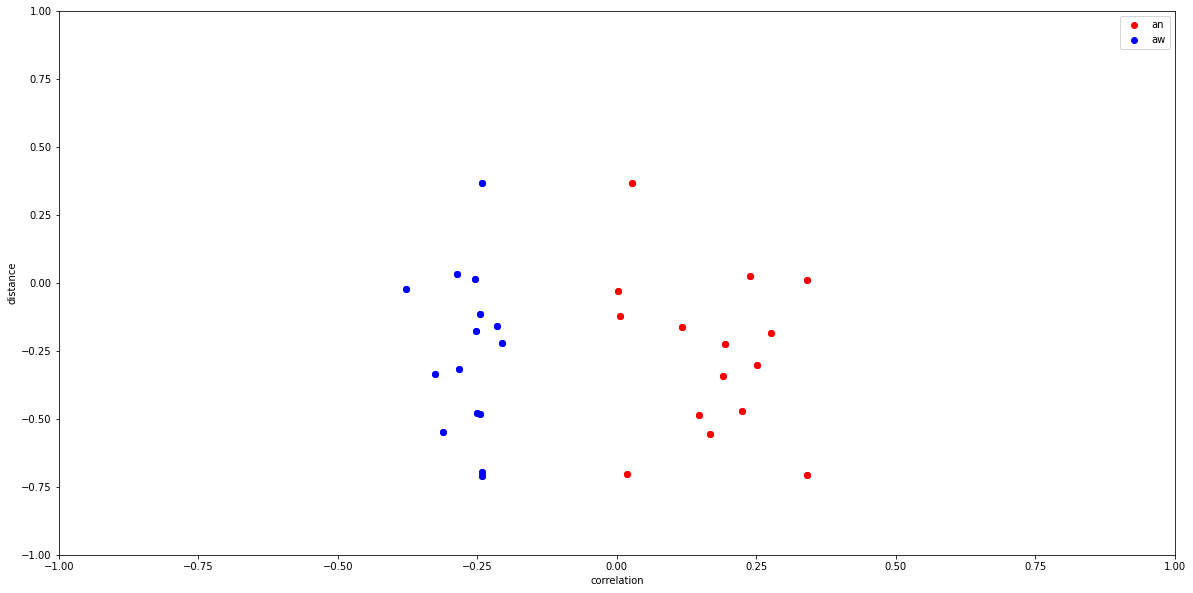

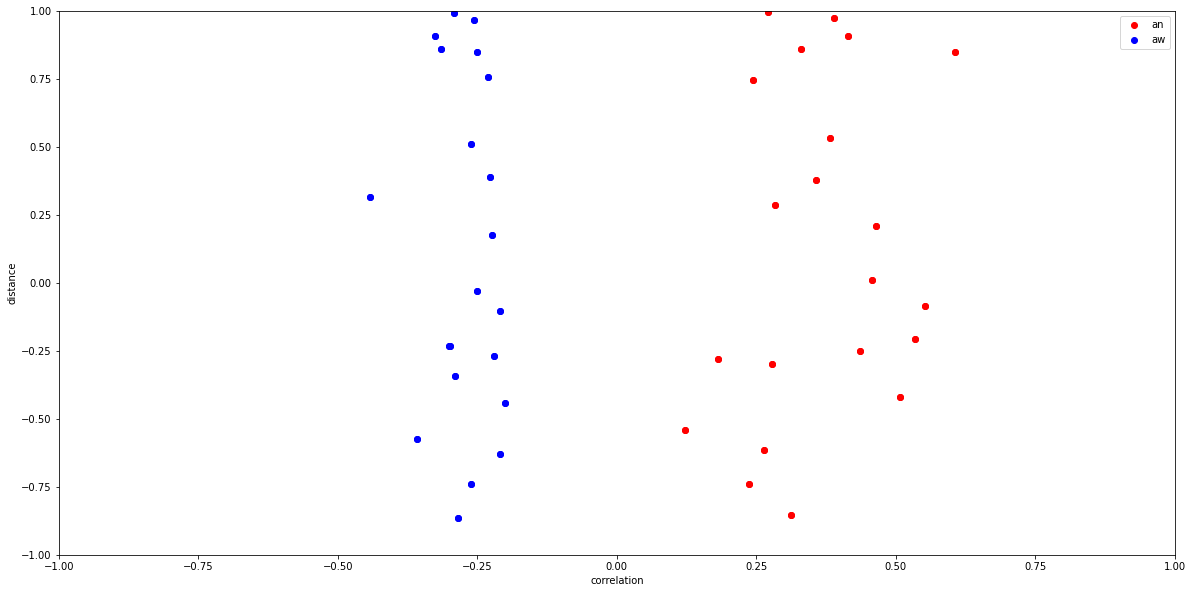

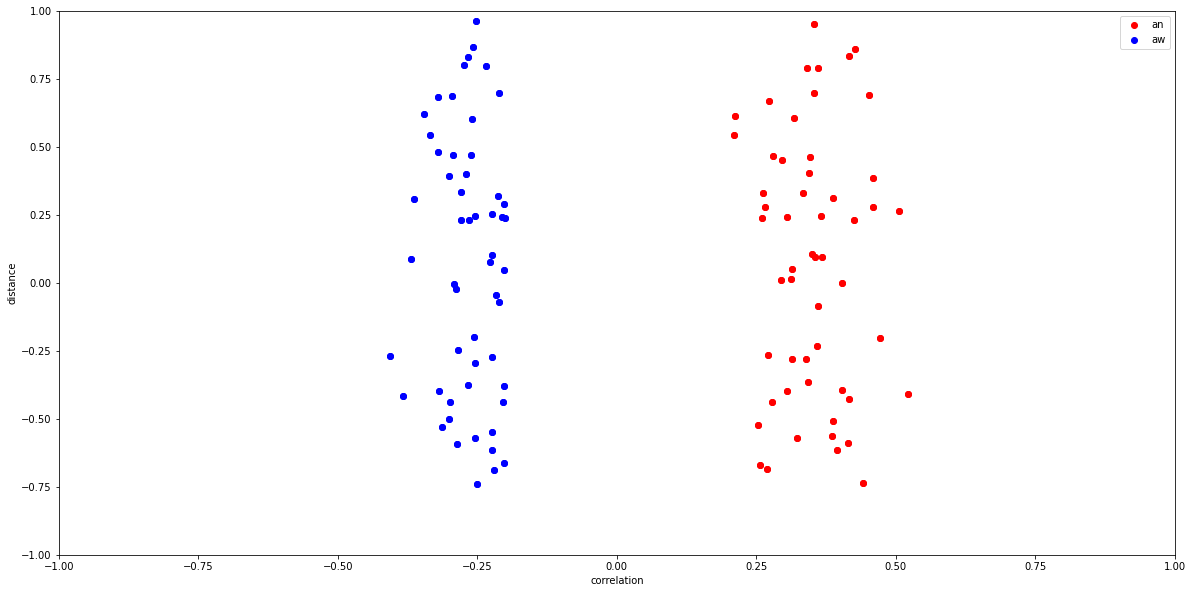

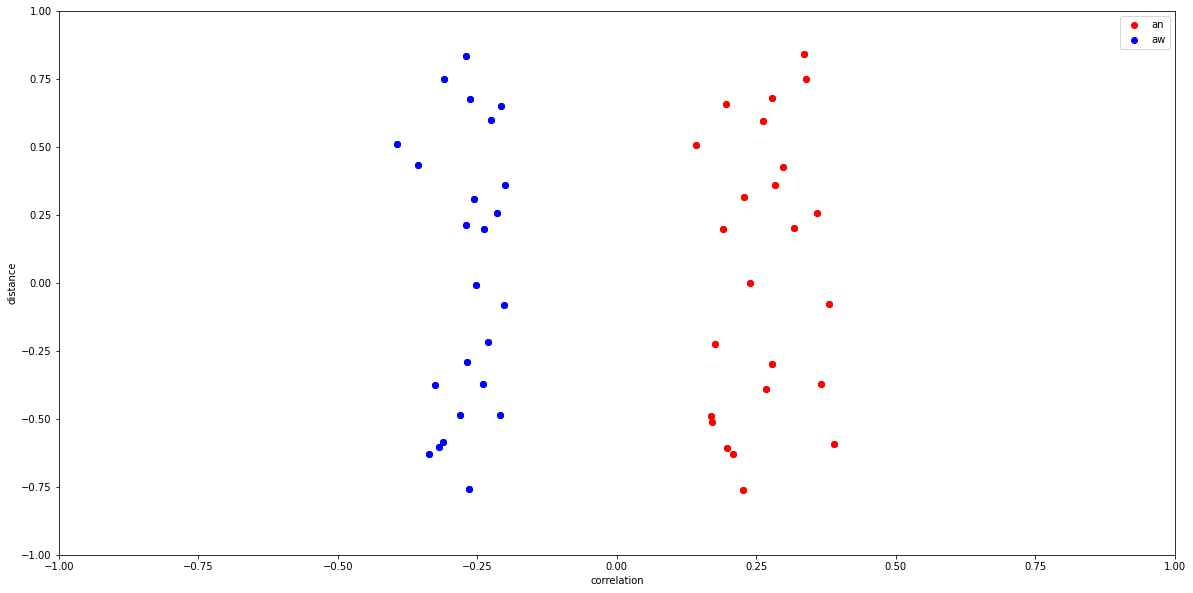

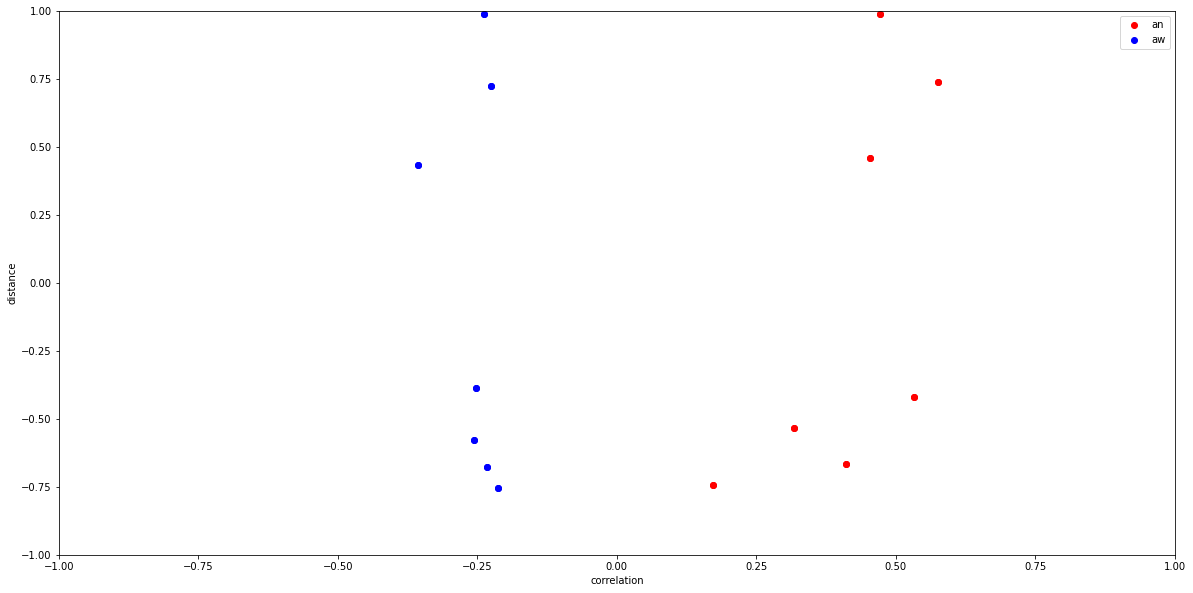

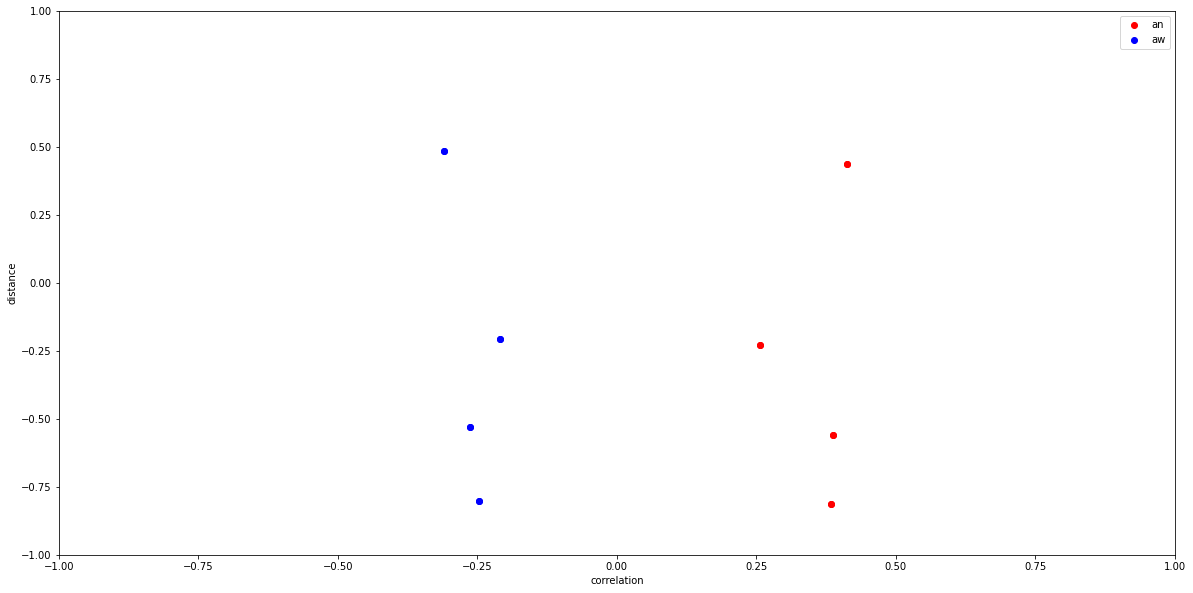

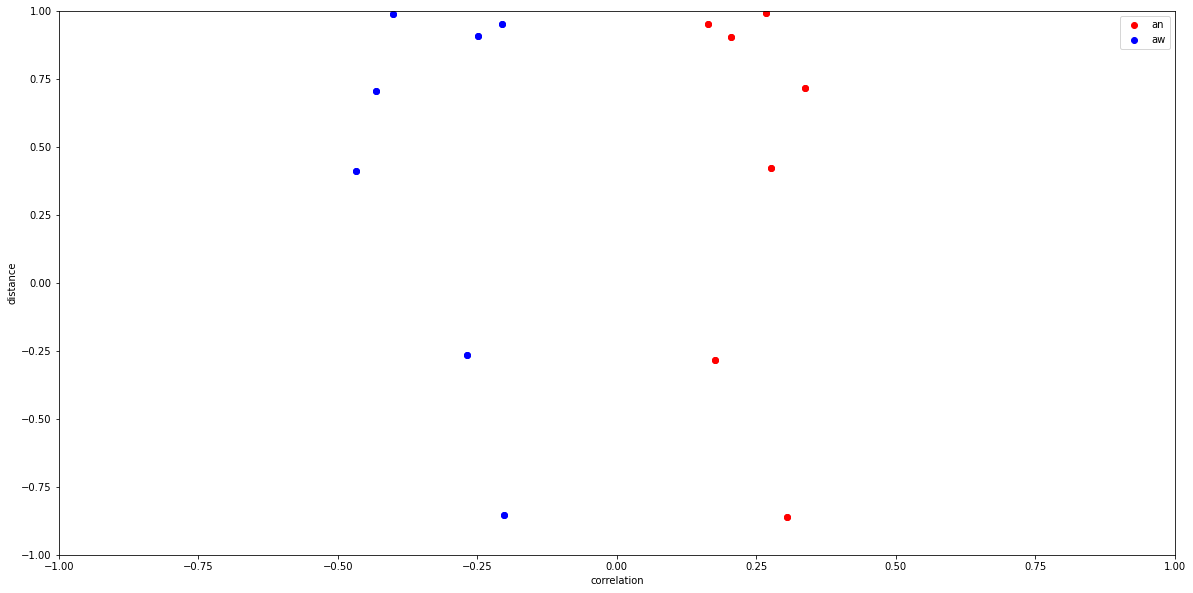

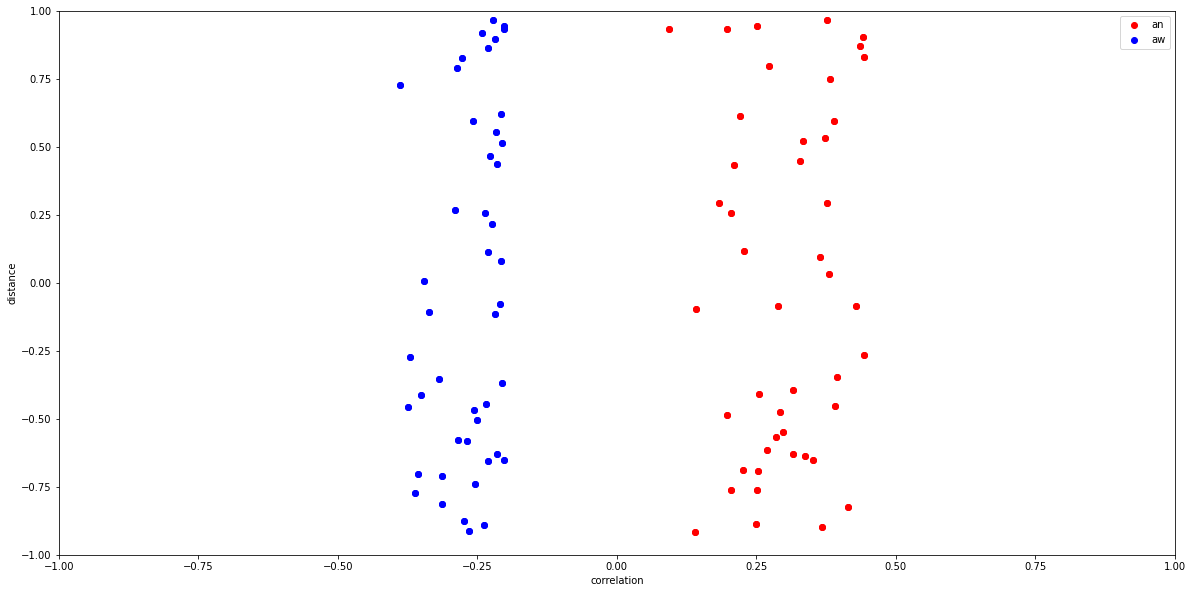

In [14]:
#lenghts of each trial
index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

for trial in range(1,len(index)):
    
    index, dat_tr, dat_stan, dat_staw = divide_data(index, trial, mat_load)
    pos_tr = roi_load[index[trial-1] : index[trial]+1, :, :, :]

    #choose state
    pos_stan = pos_tr[:, :, 0, :]
    pos_staw = pos_tr[:, :, 1, :]
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        pos_sean = pos_stan[:, :, sesion]
        pos_seaw = pos_staw[:, :, sesion]

        #make dict to convert to dataframe
        dat_df_an, dat_df_aw = make_dict(dat_sean, dat_seaw)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an, df_corr_aw = exclude_nan(dat_df_an, dat_df_aw)

        df_corr_an_pos = pd.DataFrame(index=df_corr_an.index, columns=df_corr_an.columns)
        df_corr_aw_pos = pd.DataFrame(index=df_corr_aw.index, columns=df_corr_aw.columns)
        
        for i in df_corr_an.index:
            for j in df_corr_an.columns:
                df_corr_an_pos.loc[i, j] = np.sqrt((pos_sean[i, 0]-pos_sean[j,0])**2 + (pos_sean[i, 1]-pos_sean[j,1])**2)
                df_corr_aw_pos.loc[i, j] = np.sqrt((pos_seaw[i, 0]-pos_seaw[j,0])**2 + (pos_seaw[i, 1]-pos_seaw[j,1])**2)

        df_corr_an_pos = pd.DataFrame(df_corr_an_pos, index=None).astype(float)
        df_corr_aw_pos = pd.DataFrame(df_corr_aw_pos, index=None).astype(float)
        df_corr_an_pos = df_corr_an_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
        df_corr_aw_pos = df_corr_aw_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

        #only look at the anticoorrelated ones in awake condition, and coresponding ones in anesthrized condition
        df_corr_aw[df_corr_aw > -0.2] = nan
        ll = df_corr_aw < -0.2
        df_corr_an = df_corr_an*ll
        df_corr_an[df_corr_an == 0] = nan

        #unstacking the data for plotting
        df_an_line = df_corr_an.unstack()
        df_aw_line = df_corr_aw.unstack()
        df_an_line_pos = df_corr_an_pos.unstack()
        df_aw_line_pos = df_corr_aw_pos.unstack()

        #plot the correlation distribution
        f, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_xlabel('correlation')
        ax.set_ylabel('distance')

        ax.plot(df_an_line, df_an_line_pos, 'o', color='red', label='activity')
        ax.plot(df_aw_line, df_aw_line_pos, 'o', color='blue', label='awakening')
        ax.legend(['an', 'aw'])  
    
    break